In [1]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
import ast
import pandas as pd


### Load in scores and outputs from BoN (up to 32)

In [3]:
# file with softlabels produced in query-adaptive-router-mv-bon.
output_file = "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/best_of_32/softlabel_predictor_df.csv"
# predictor_df.to_csv(output_file, index=False)

# read don_df with softlabels.
predictor_df = pd.read_csv(output_file)
predictor_df.head(), predictor_df.shape

(                                            question  \
 0  Convert the point $(0,3)$ in rectangular coord...   
 1  Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2...   
 2  If $f(x) = \frac{3x-2}{x-2}$, what is the valu...   
 3  How many positive whole-number divisors does 1...   
 4  The results of a cross-country team's training...   
 
                                                score  \
 0  [1.0, 0.169921875, 1.0, 0.361328125, 1.0, 1.0,...   
 1  [0.640625, 0.98046875, 0.0030822754, 1.0, 0.12...   
 2  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
 3  [0.9921875, 1.0, 1.0, 0.9921875, 1.0, 0.90625,...   
 4  [0.9609375, 0.99609375, 0.99609375, 0.9921875,...   
 
                                    completion_tokens  sb_idx    sl  N  \
 0  [271, 290, 269, 220, 220, 403, 261, 310, 260, ...       0  0.64  2   
 1  [1064, 872, 964, 654, 831, 680, 1384, 832, 103...       1  0.30  2   
 2  [432, 256, 460, 509, 505, 462, 437, 512, 360, ...       2  0.92  2   
 3  [441, 382, 4

#### Add Token Cost and Latency

In [4]:
# Combine with BoN Latencies: read in "latencies_df.csv"
latencies_df = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/scripts/latencies_df.csv")
# Rename "maj" to "majority"
predictor_df["method"] = predictor_df["method"].replace({"maj": "majority"})
# Combine the columns predictor and latencies.
bon_df = predictor_df.merge(
    latencies_df,
    on=["sb_idx", "N", "method"],
    how="left"
)

In [5]:
# summarize token count for each method.
bon_df.head()
# summarize token count for each method, N pair.
bon_df.groupby(["method", "N"])["token_count"].mean()

method    N 
majority  2      1049.362
          4      2101.906
          8      4177.702
          16     8283.908
          32    16516.854
naive     2      1049.362
          4      2101.906
          8      4177.702
          16     8283.908
          32    16516.854
weighted  2      1049.362
          4      2101.906
          8      4177.702
          16     8283.908
          32    16516.854
Name: token_count, dtype: float64

#### Load Beam Soft Labels

In [6]:
import importlib
import extract_sl_maj_N
importlib.reload(extract_sl_maj_N)

beam_2_4_40_softlabels = extract_sl_maj_N.extract_sl_maj_N_from_jsonl('/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/Math500_beam_search_2_4_40/softlabels_2.jsonl', 2)
beam_4_4_40_softlabels = extract_sl_maj_N.extract_sl_maj_N_from_jsonl('/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/beam_search_4_4_40/softlabels_4.jsonl', 4)
beam_8_4_40_softlabels = extract_sl_maj_N.extract_sl_maj_N_from_jsonl('/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/beam_search_8_4_40/softlabels_8.jsonl', 8)
beam_16_4_40_softlabels = extract_sl_maj_N.extract_sl_maj_N_from_jsonl('/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/beam_search_16_4_40/softlabels_16.jsonl', 16)
beam_32_4_40_softlabels = extract_sl_maj_N.extract_sl_maj_N_from_jsonl('/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/beam_search_32_4_40/softlabels_32.jsonl', 32)

In [7]:
# concatenate beam softlabel files into one file.
import numpy as np

beam_sl_all = pd.concat([beam_2_4_40_softlabels, beam_4_4_40_softlabels, beam_8_4_40_softlabels, beam_16_4_40_softlabels, beam_32_4_40_softlabels], ignore_index=True)
beam_sl_all.head()
beam_sl_all.shape

(2500, 4)

#### Read in Beam-Search Files.

In [8]:
def load_jsonl_extract_for_N(jsonl_path, N):
    data = []

    with open(jsonl_path, "r") as f:
        for line in f:
            entry = json.loads(line)
            question = entry["problem"]
            score_list = entry["agg_scores"] 
            completion_tokens = entry["completion_tokens"]
            indicator_weighted = entry.get(f"indicator_weighted@{N}")
            indicator_naive = entry.get(f"indicator_naive@{N}")
            indicator_maj = entry.get(f"indicator_maj@{N}")
            correctness = entry.get(f"correctness@{N}")

            data.append({
                "question": question,
                "score": score_list,
                "completion_tokens": completion_tokens,
                f"indicator": indicator_maj,
                # f"correctness": correctness,
                "method": "beam_search",
                "N": N,
            })

    return pd.DataFrame(data)

In [9]:
beam_2_4_40 = load_jsonl_extract_for_N('/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/Math500_beam_search_2_4_40/beam_search_completions.jsonl', 2)
beam_4_4_40 = load_jsonl_extract_for_N('/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/beam_search_4_4_40/beam_search_completions.jsonl', 4)
beam_8_4_40 = load_jsonl_extract_for_N('/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/Math500_beam_search_8_4_40/beam_search_completions.jsonl', 8)
beam_16_4_40 = load_jsonl_extract_for_N('/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/Math500_beam_search_16_4_40/beam_search_completions.jsonl', 16)
beam_32_4_40 = load_jsonl_extract_for_N('/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/beam_search_32_4_40/beam_search_completions.jsonl', 32)

In [10]:
# add question index.
beam_2_4_40["sb_idx"] = beam_2_4_40.index.tolist()
beam_4_4_40["sb_idx"] = beam_4_4_40.index.tolist()
beam_8_4_40["sb_idx"] = beam_8_4_40.index.tolist()
beam_16_4_40["sb_idx"] = beam_16_4_40.index.tolist()
beam_32_4_40["sb_idx"] = beam_32_4_40.index.tolist()

# concatenate all beam search dataframes.
beam_df = pd.concat([beam_2_4_40, beam_4_4_40, beam_8_4_40, beam_16_4_40, beam_32_4_40], ignore_index=True)

In [11]:
# join beam_df with beam_sl_all.
beam_df_with_sl = pd.merge(
    beam_df,
    beam_sl_all,
    on=["sb_idx", "N", "method"],
    how="outer"
)

In [13]:
# Compute length of question (aka, length of the string)
beam_df_with_sl["question_length"] = beam_df_with_sl["question"].str.len()

#### Get times and latencies for beam.

In [14]:
# Get times and latencies for beam search from the log file.
import re
import pandas as pd

def extract_latency_and_tokens_with_index(log_path, N):
    with open(log_path, "r") as f:
        lines = f.readlines()

    latencies = []
    total_tokens = []
    question_indices = []

    token_pattern = re.compile(r"Total number of tokens generated thus far: (\d+)")
    time_pattern = re.compile(r"Total beam search time: ([\d.]+) seconds")

    previous_token_count = 0
    question_index = 0

    for i, line in enumerate(lines):
        time_match = time_pattern.search(line)
        if time_match:
            # Find the most recent total token count before the current time line
            for j in range(i - 1, -1, -1):
                token_match = token_pattern.search(lines[j])
                if token_match:
                    current_token_count = int(token_match.group(1))
                    token_diff = current_token_count - previous_token_count
                    previous_token_count = current_token_count
                    break

            latency = float(time_match.group(1))

            latencies.append(latency)
            total_tokens.append(token_diff)
            question_indices.append(question_index)
            question_index += 1

    # Build DataFrame
    df = pd.DataFrame({
        "sb_idx": question_indices,
        "time": latencies,
        "token_count": total_tokens,
        "method": "beam_search",
        "N": N,
    })

    return df

In [15]:
beam2 = '/dccstor/gma2/jhjenny9/search-and-learn/cow2.out'
beam4 = '/dccstor/gma2/jhjenny9/search-and-learn/cow4.out'
beam8 = '/dccstor/gma2/jhjenny9/search-and-learn/cow8.out'
beam16 = '/dccstor/gma2/jhjenny9/search-and-learn/cow16.out'
beam32 = '/dccstor/gma2/jhjenny9/search-and-learn/cow32.out'
beam2_timelate  = extract_latency_and_tokens_with_index(beam2, 2)
beam4_timelate  = extract_latency_and_tokens_with_index(beam4, 4)
beam8_timelate  = extract_latency_and_tokens_with_index(beam8, 8)
beam16_timelate = extract_latency_and_tokens_with_index(beam16, 16)
beam32_timelate = extract_latency_and_tokens_with_index(beam32, 32)
beam2_timelate.head()

,sb_idx,time,token_count,method,N
0,0,3.90,419,beam_search,2
1,1,6.27,1505,beam_search,2
2,2,3.04,838,beam_search,2
3,3,5.83,1227,beam_search,2
4,4,7.05,1416,beam_search,2


In [16]:
# concatenate all beam search latency dataframes.
beam_timelate = pd.concat(
    [beam2_timelate, beam4_timelate, beam8_timelate, beam16_timelate, beam32_timelate], ignore_index=True
)

In [17]:
beam_timelate.head()

,sb_idx,time,token_count,method,N
0,0,3.90,419,beam_search,2
1,1,6.27,1505,beam_search,2
2,2,3.04,838,beam_search,2
3,3,5.83,1227,beam_search,2
4,4,7.05,1416,beam_search,2


In [18]:
# Combine the columns df_test and latencies_for_df_test.
beam_df = beam_df_with_sl.merge(
    beam_timelate,
    on=["sb_idx", "N", "method"],
    how="left"
)

#### Concatenate Beam and BoN DFs

In [19]:
predictor_df = pd.concat([bon_df, beam_df], ignore_index=True)
# drop the indicator column.
predictor_df.drop(columns=["indicator", "method_maj", "method_naive", "method_weighted"], inplace=True)
predictor_df.tail()

,question,score,completion_tokens,sb_idx,sl,N,question_length,token_count,method,time
9995,Altitudes $\overline{AD}$ and $\overline{BE}$ ...,"[1.0, 0.94140625]","[231, 311]",499,0.52,2,166,787,beam_search,3.19
9996,Altitudes $\overline{AD}$ and $\overline{BE}$ ...,"[1.0, 1.0, 1.0, 1.0]","[274, 271, 276, 276]",499,1.00,4,166,984,beam_search,2.40
9997,Altitudes $\overline{AD}$ and $\overline{BE}$ ...,"[1.0, 1.0, 0.99609375, 0.99609375, 0.9921875, ...","[201, 202, 197, 197, 456, 456, 456, 470]",499,0.52,8,166,23550,beam_search,45.54
9998,Altitudes $\overline{AD}$ and $\overline{BE}$ ...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[336, 244, 336, 245, 336, 242, 331, 250, 374, ...",499,0.98,16,166,10514,beam_search,20.55
9999,Altitudes $\overline{AD}$ and $\overline{BE}$ ...,"[0.0016708374, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1...","[305, 300, 303, 303, 298, 295, 357, 347, 295, ...",499,1.00,32,166,23320,beam_search,37.34


In [20]:
# save predictor_df to csv.
output_file = "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/parallel_best_of_32/df_bon_beam_softlabels.csv"
# predictor_df.to_csv(output_file, index=False)

# read predictor_df from csv.
predictor_df = pd.read_csv(output_file)
predictor_df.head()

,question,score,completion_tokens,sb_idx,sl,N,question_length,token_count,method,time
0,"Convert the point $(0,3)$ in rectangular coord...","[1.0, 0.169921875, 1.0, 0.361328125, 1.0, 1.0,...","[271, 290, 269, 220, 220, 403, 261, 310, 260, ...",0,0.64,2,161,561,weighted,3.56
1,Define\n\[p = \sum_{k = 1}^\infty \frac{1}{k^2...,"[0.640625, 0.98046875, 0.0030822754, 1.0, 0.12...","[1064, 872, 964, 654, 831, 680, 1384, 832, 103...",1,0.30,2,217,1936,weighted,7.81
2,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[432, 256, 460, 509, 505, 462, 437, 512, 360, ...",2,0.92,2,113,688,weighted,2.20
3,How many positive whole-number divisors does 1...,"[0.9921875, 1.0, 1.0, 0.9921875, 1.0, 0.90625,...","[441, 382, 489, 163, 415, 248, 250, 251, 354, ...",3,0.92,2,54,823,weighted,1.61
4,The results of a cross-country team's training...,"[0.9609375, 0.99609375, 0.99609375, 0.9921875,...","[476, 307, 330, 468, 781, 203, 427, 746, 340, ...",4,0.64,2,731,783,weighted,2.29


In [ ]:
# plot average token count by method and N.
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.barplot(
    data=predictor_df,
    x='N',
    y='time',
    hue='method',
    ci=None,
    palette='viridis'
)
# plt.title('Average Token Count by Method and N')
plt.xlabel('N (Number of Completions)')
plt.ylabel('Time Per Query (sec)')
plt.legend(title='Method')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# sanity check that melting worked correctly.
# predictor_df[predictor_df["sb_idx"] == 1]
# type(predictor_df["completion_tokens"][0]) 

### change completion_tokens to a list of ints.
# predictor_df["completion_tokens"] = predictor_df["completion_tokens"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

#### Add method columns 1-hot (for training) and combined (for routing).

In [22]:
predictor_df = pd.get_dummies(predictor_df, columns=["method"])


In [23]:
# Transform method columns into a single 'method' column.
def decode_method(row):
    if row["method_majority"]:
        return "majority"
    elif row["method_naive"]:
        return "naive"
    elif row["method_weighted"]:
        return "weighted"
    elif row["method_beam_search"]:
        return "beam_search"
    else:
        return "unknown"

# Apply the function row-wise
predictor_df["method"] = predictor_df.apply(decode_method, axis=1)

In [24]:
# find the mean token_count for each method and N.
mean_token_count = predictor_df.groupby(["method", "N"])["token_count"].mean()
mean_token_count

method       N 
beam_search  2      1402.114
             4      3145.578
             8      7122.170
             16    16203.502
             32    36738.184
majority     2      1049.362
             4      2101.906
             8      4177.702
             16     8283.908
             32    16516.854
naive        2      1049.362
             4      2101.906
             8      4177.702
             16     8283.908
             32    16516.854
weighted     2      1049.362
             4      2101.906
             8      4177.702
             16     8283.908
             32    16516.854
Name: token_count, dtype: float64

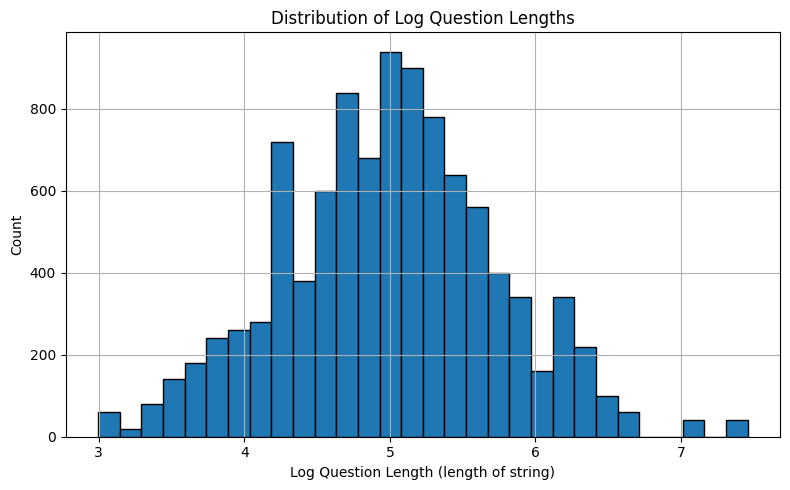

In [25]:
import matplotlib.pyplot as plt

# Create histogram
plt.figure(figsize=(8, 5))
plt.hist(np.log(predictor_df["question_length"]), bins=30, edgecolor='black')

plt.xlabel("Log Question Length (length of string)")
plt.ylabel("Count")
plt.title("Distribution of Log Question Lengths")
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

In [26]:
# create train/test split based on 'sb_idx' (query identifier)
from sklearn.model_selection import train_test_split

unique_sb_idx = predictor_df['sb_idx'].unique()

# Split sb_idx into train/test
sb_idx_train, sb_idx_test = train_test_split(
    unique_sb_idx,
    test_size=0.20, # .15
    random_state=6
)

# Divide queries (represented by sb_idx) into train and test
df_train = predictor_df[predictor_df['sb_idx'].isin(sb_idx_train)].reset_index(drop=True)
df_test = predictor_df[predictor_df['sb_idx'].isin(sb_idx_test)].reset_index(drop=True)

In [2]:
# save train and test dataframes to csv df_train_math500.csv and df_test_math500.csv
# df_train.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_train_math500.csv", index=False)
# df_test.to_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_test_math500.csv", index=False) 

# read in train and test dataframes from csv
df_train = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_train_math500.csv")
df_test = pd.read_csv("/dccstor/gma2/jhjenny9/search-and-learn/data/df_test_math500.csv")

In [3]:
df_train.shape, df_test.shape

((8000, 14), (2000, 14))

### Extract Features for Difficulty Probe.

In [4]:
df_test.head()

,question,score,completion_tokens,sb_idx,sl,N,question_length,token_count,time,method_beam_search,method_majority,method_naive,method_weighted,method
0,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[432, 256, 460, 509, 505, 462, 437, 512, 360, ...",2,0.92,2,113,688,2.20,False,False,False,True,weighted
1,What is the least positive integer multiple of...,"[0.86328125, 0.0708007812, 0.5546875, 0.878906...","[512, 316, 1032, 412, 609, 423, 354, 431, 595,...",10,0.14,2,99,828,3.23,False,False,False,True,weighted
2,"The proper divisors of 12 are 1, 2, 3, 4 and 6...","[0.640625, 1.0, 0.99609375, 1.0, 0.1137695312,...","[176, 365, 285, 839, 427, 359, 355, 411, 300, ...",12,0.08,2,215,541,2.12,False,False,False,True,weighted
3,The volume of the cylinder shown is $45\pi$ cu...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[277, 248, 237, 251, 221, 198, 152, 248, 282, ...",13,1.00,2,384,525,1.08,False,False,False,True,weighted
4,Compute: $1-2+3-4+5- \dots +99-100$.,"[1.0, 1.0, 1.0, 1.0, 0.99609375, 1.0, 1.0, 0.9...","[152, 262, 236, 215, 178, 264, 226, 202, 239, ...",16,0.84,2,36,414,1.60,False,False,False,True,weighted


### Load in Training/Testing Data

In [5]:
# read in output from extract_features.py: X_train and y_train hard labels from .npz file.
# output_X_train = "/dccstor/gma2/jhjenny9/search-and-learn/data/qwen2-sl-embeddings/X_train.npy"
output_X_train = "/dccstor/gma2/jhjenny9/search-and-learn/results/math500_improved/processed_data/X_train_combined.npy"
# output_y_train = "/dccstor/gma2/jhjenny9/search-and-learn/data/qwen-sl-embeddings/y_train.npy"
X_train = np.load(output_X_train)
y_train = df_train["sl"].values.astype(float)
output_X_test = "/dccstor/gma2/jhjenny9/search-and-learn/results/math500_improved/processed_data/X_test_combined.npy"
# output_y_test = "/dccstor/gma2/jhjenny9/search-and-learn/data/qwen-sl-embeddings/y_test.npy"
X_test = np.load(output_X_test)
y_test = df_test["sl"].values.astype(float)


In [6]:
X_train.shape

(8000, 1596)

In [ ]:
1596 - 1536 # 60, each auxiliary features is repeated 10 times.

60

### Plotting Feature Importance.

In [8]:
# split high-dimensional CLS and interpretable features
cls_dim = 1536 # len(cls_vec)
cls_part = X_train[:, :cls_dim]
# named_features = pd.DataFrame(
#     X_train[:, cls_dim:],  # shape (n_samples, 5)
#     columns=["num_samples", "question_length", "method_maj", "method_naive", "method_weighted", "method_beam_search"]
# )

In [ ]:
named_features["method_beam_search"].value_counts()

method_beam_search
0.0    6000
1.0    2000
Name: count, dtype: int64

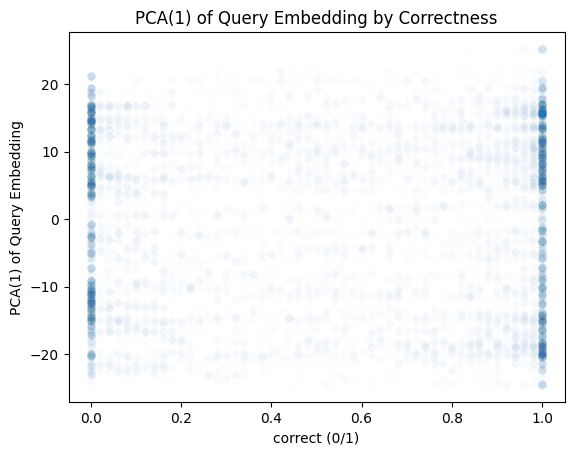

In [11]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce to 1D or 2D
pca = PCA(n_components=1)
cls_1d = pca.fit_transform(cls_part)[:, 0]

# Plot 1D PCA of CLS
sns.scatterplot(x=y_train, y=cls_1d, alpha=1e-2)
plt.title("PCA(1) of Query Embedding by Correctness")
plt.xlabel("correct (0/1)")
plt.ylabel("PCA(1) of Query Embedding")
plt.show()

### Train MLP.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

In [14]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8000, 1596), (8000,), (2000, 1596), (2000,))

#### Train Enhanced MLP

In [48]:
X_train_emb = np.load("/dccstor/gma2/jhjenny9/search-and-learn/results/math500_improved/processed_data/X_train_embeddings.npy")
X_train_aux = np.load("/dccstor/gma2/jhjenny9/search-and-learn/results/math500_improved/processed_data/X_train_auxiliary.npy")
y_train =  np.load("/dccstor/gma2/jhjenny9/search-and-learn/results/math500_improved/processed_data/y_train.npy")

X_test_emb = np.load("/dccstor/gma2/jhjenny9/search-and-learn/results/math500_improved/processed_data/X_test_embeddings.npy")
X_test_aux = np.load("/dccstor/gma2/jhjenny9/search-and-learn/results/math500_improved/processed_data/X_test_auxiliary.npy")
y_test =  np.load("/dccstor/gma2/jhjenny9/search-and-learn/results/math500_improved/processed_data/y_test.npy")


In [49]:
y_test

array([0.92, 0.14, 0.08, ..., 0.52, 0.98, 1.  ])

In [51]:
import train_enhanced_mlp
import os

# Create datasets
train_dataset = train_enhanced_mlp.EnhancedDataset(X_train_emb, X_train_aux, y_train)
test_dataset = train_enhanced_mlp.EnhancedDataset(X_test_emb, X_test_aux, y_test)

data_dir = "/dccstor/gma2/jhjenny9/search-and-learn/results/math500_improved/processed_data"
# Load model info
with open(os.path.join(data_dir, "model_info.json"), 'r') as f:
    model_info = json.load(f)

print(f"Data shapes:")
print(f"  Train embeddings: {X_train_emb.shape}")
print(f"  Train auxiliary: {X_train_aux.shape}")
print(f"  Test embeddings: {X_test_emb.shape}")
print(f"  Test auxiliary: {X_test_aux.shape}")

# Training configuration
config = {
    'batch_size': 128,
    'learning_rate': 1e-4,
    'weight_decay': 0,
    'num_epochs': 100,
    'patience': 20,
    'hidden_dims': [32, 16],
    'dropout_rate': 0.2
}

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)



Data shapes:
  Train embeddings: (8000, 1536)
  Train auxiliary: (8000, 60)
  Test embeddings: (2000, 1536)
  Test auxiliary: (2000, 60)


In [52]:
import importlib
import train_enhanced_mlp  # Reload enhanced MLP.
importlib.reload(train_enhanced_mlp)
import torch
from torch import nn
from torch import optim

# Create model
model = train_enhanced_mlp.EnhancedMLP(
    embedding_dim=model_info['embedding_dim'],
    auxiliary_dim=model_info['auxiliary_dim'],
    hidden_dims=config['hidden_dims'],
    dropout_rate=config['dropout_rate']
).to("cpu")

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(
    model.parameters(), 
    lr=config['learning_rate'], 
    weight_decay=config['weight_decay']
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, verbose=True
)

/dccstor/gma2/jhjenny9/envs/model_serve/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [53]:
# =========================
# Training Functions
# =========================
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for (emb_features, aux_features), labels in train_loader:
        emb_features = emb_features.to(device)
        aux_features = aux_features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(emb_features, aux_features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    num_batches = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for (emb_features, aux_features), labels in val_loader:
            emb_features = emb_features.to(device)
            aux_features = aux_features.to(device)
            labels = labels.to(device)
            
            outputs = model(emb_features, aux_features)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            num_batches += 1
            
            all_predictions.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    predictions = np.array(all_predictions).flatten()
    true_labels = np.array(all_labels).flatten()
    
    # For soft labels, use MSE
    mse = mean_squared_error(true_labels, predictions)
    
    # For binary classification (if needed), convert to binary
    binary_predictions = (predictions >= 0.5).astype(int)
    binary_labels = (true_labels >= 0.5).astype(int)
    accuracy = accuracy_score(binary_labels, binary_predictions)
    
    return total_loss / num_batches, mse, accuracy

In [54]:
output_dir = "/dccstor/gma2/jhjenny9/search-and-learn/results/math500_improved/trained_model"
from sklearn.metrics import accuracy_score, mean_squared_error

# Training loop
train_losses = []
val_losses = []
val_mses = []
val_accuracies = []

best_val_loss = float('inf')
patience_counter = 0

print(f"\n{'Epoch':<6} {'Train Loss':<12} {'Val Loss':<12} {'Val MSE':<12} {'Val Acc':<8} {'LR':<10}")
print("-" * 70)

for epoch in range(config['num_epochs']):
    # Training
    train_loss = train_epoch(model, train_loader, criterion, optimizer, "cpu")
    
    # Validation
    val_loss, val_mse, val_accuracy = validate_epoch(model, test_loader, criterion, "cpu")
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Record metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_mses.append(val_mse)
    val_accuracies.append(val_accuracy)
    
    # Print formatted output
    print(f"{epoch+1:<6} {train_loss:<12.6f} {val_loss:<12.6f} {val_mse:<12.6f} {val_accuracy:<8.4f} {optimizer.param_groups[0]['lr']:<10.2e}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        
        # Save best model
        os.makedirs(output_dir, exist_ok=True)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'config': config
        }, os.path.join(output_dir, 'best_model.pth'))
        
    else:
        patience_counter += 1
        if patience_counter >= config['patience']:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print("-" * 70)
print(f"Training completed. Best validation loss: {best_val_loss:.6f}")


Epoch  Train Loss   Val Loss     Val MSE      Val Acc  LR        
----------------------------------------------------------------------
1      0.656902     0.628554     0.143774     0.6935   1.00e-04  
2      0.590425     0.595099     0.130181     0.6880   1.00e-04  
3      0.539848     0.587465     0.127905     0.6935   1.00e-04  
4      0.504415     0.587085     0.127727     0.6970   1.00e-04  
5      0.472274     0.588919     0.127895     0.7010   1.00e-04  
6      0.448758     0.594708     0.129806     0.6995   1.00e-04  
7      0.422447     0.598436     0.130234     0.7050   1.00e-04  
8      0.409583     0.605999     0.131873     0.7005   1.00e-04  
9      0.391899     0.612387     0.132836     0.7015   1.00e-04  
10     0.382590     0.618390     0.134102     0.7040   1.00e-04  
11     0.373683     0.627783     0.136214     0.7010   1.00e-04  
12     0.362856     0.630440     0.135505     0.7055   1.00e-04  
13     0.359152     0.641653     0.138756     0.6975   1.00e-04  
14  

### Create Custom MLP

In [16]:
import torch
import torch.nn as nn                       
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [55]:
# load in X_train and X_test
X_train = np.load("/dccstor/gma2/jhjenny9/search-and-learn/results/math500_improved/processed_data/X_train_combined.npy")
X_test = np.load("/dccstor/gma2/jhjenny9/search-and-learn/results/math500_improved/processed_data/X_test_combined.npy")

# load in y_train and y_test
y_train = np.load("/dccstor/gma2/jhjenny9/search-and-learn/results/math500_improved/processed_data/y_train.npy")
y_test = np.load("/dccstor/gma2/jhjenny9/search-and-learn/results/math500_improved/processed_data/y_test.npy")


In [65]:
# ----- 2. Dataset Definition -----
class SoftLabelDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ----- 3. Dataloaders -----
train_dataset = SoftLabelDataset(X_train, y_train)
val_dataset = SoftLabelDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# ----- 4. MLP Model - following from the LLM Routing Paper. -----
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),  # First layer with 200 hidden units
            nn.GELU(),                 # GELU activation
            nn.Dropout(0.2),           # Dropout to prevent overfitting
            nn.Linear(32, 32),       # Second layer with 200 hidden units
            nn.GELU(),                 # GELU activation
            nn.Dropout(0.2),           # Dropout to prevent overfitting
            nn.Linear(32, 1),         # Output layer
            nn.Sigmoid()               # Sigmoid for binary cross-entropy with soft targets
        )

    def forward(self, x):
        return self.model(x)

model = MLP(input_dim=1596)

# ----- 5. Loss and Optimizer -----
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for soft binary targets
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [66]:
# ----- 6. Training Loop -----
num_epochs = 100  # Maximum of 10,000 epochs
batch_size = 128    # Batch size of 128
patience = 10      # Early stopping patience

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

agg_train_loss = []
agg_val_loss = []
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = []
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    # Validation
    model.eval()
    val_loss = []
    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_preds = model(val_X)
            val_loss.append(criterion(val_preds, val_y).item())
    mean_train_loss = np.mean(train_loss)
    mean_val_loss = np.mean(val_loss)

    agg_train_loss.append(mean_train_loss)
    agg_val_loss.append(mean_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {mean_train_loss:.4f}, Val Loss: {mean_val_loss:.4f}")

    # Early stopping
    if mean_val_loss < best_val_loss:
        best_val_loss = mean_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1, Train Loss: 0.6879, Val Loss: 0.6740
Epoch 2, Train Loss: 0.6779, Val Loss: 0.6678
Epoch 3, Train Loss: 0.6688, Val Loss: 0.6619
Epoch 4, Train Loss: 0.6599, Val Loss: 0.6565
Epoch 5, Train Loss: 0.6511, Val Loss: 0.6514
Epoch 6, Train Loss: 0.6435, Val Loss: 0.6463
Epoch 7, Train Loss: 0.6351, Val Loss: 0.6415
Epoch 8, Train Loss: 0.6277, Val Loss: 0.6367
Epoch 9, Train Loss: 0.6205, Val Loss: 0.6321
Epoch 10, Train Loss: 0.6121, Val Loss: 0.6275
Epoch 11, Train Loss: 0.6050, Val Loss: 0.6235
Epoch 12, Train Loss: 0.5965, Val Loss: 0.6196
Epoch 13, Train Loss: 0.5906, Val Loss: 0.6164
Epoch 14, Train Loss: 0.5835, Val Loss: 0.6135
Epoch 15, Train Loss: 0.5769, Val Loss: 0.6109
Epoch 16, Train Loss: 0.5691, Val Loss: 0.6086
Epoch 17, Train Loss: 0.5628, Val Loss: 0.6067
Epoch 18, Train Loss: 0.5577, Val Loss: 0.6052
Epoch 19, Train Loss: 0.5527, Val Loss: 0.6036
Epoch 20, Train Loss: 0.5467, Val Loss: 0.6024
Epoch 21, Train Loss: 0.5419, Val Loss: 0.6013
Epoch 22, Train Loss: 

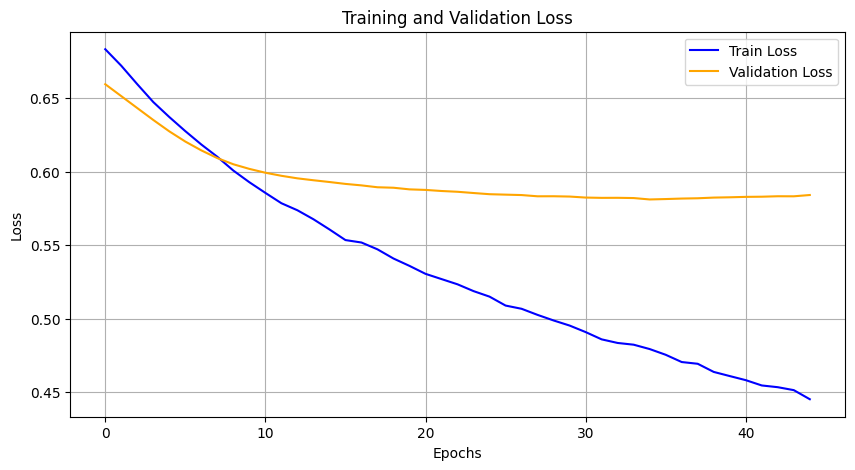

In [58]:
# ----- 7. Plot Training and Validation Loss -----
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(agg_train_loss, label='Train Loss', color='blue')
plt.plot(agg_val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

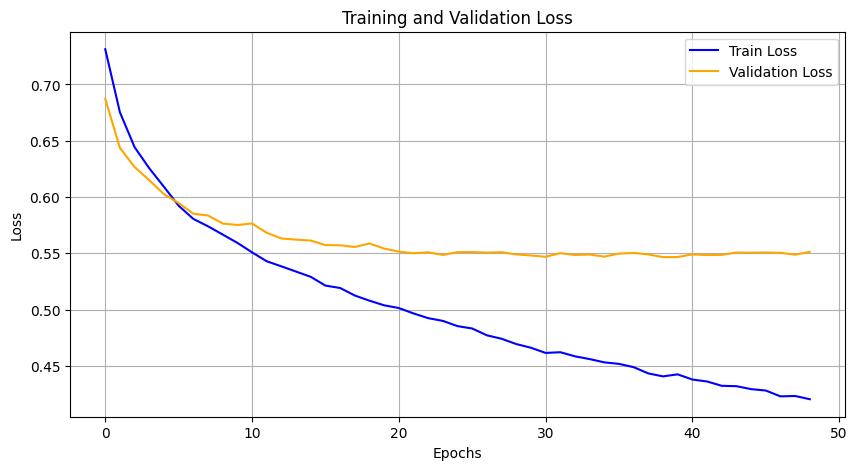

In [ ]:
# ----- 7. Plot Training and Validation Loss -----
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(agg_train_loss, label='Train Loss', color='blue')
plt.plot(agg_val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Make Predictions on Test.

In [33]:
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

with torch.no_grad():
    softLabel_Preds = model(X_test_tensor)

In [ ]:
# softLabel_preds_numpy = softLabel_Preds.squeeze().cpu().numpy()
# softLabel_preds_numpy

array([0.90861034, 0.6003232 , 0.50664407, ..., 0.34463236, 0.39192668,
       0.49652705], dtype=float32)

In [77]:
# load in softLabel_preds_numpy
softLabel_preds = np.load("/dccstor/gma2/jhjenny9/search-and-learn/results/math500_improved/trained_model/test_predictions.npy")
softLabel_preds_2 = np.load("/dccstor/gma2/jhjenny9/search-and-learn/results/math500_improved/trained_model_2/test_predictions.npy")
# load in y_test
y_test = np.load("/dccstor/gma2/jhjenny9/search-and-learn/results/math500_improved/processed_data/y_test.npy")

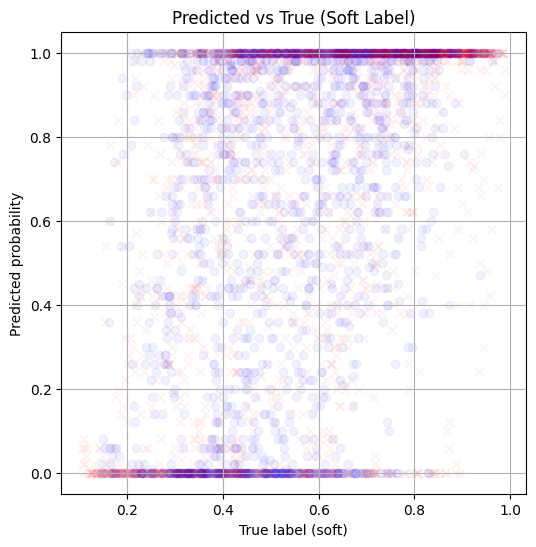

In [79]:
plt.figure(figsize=(6, 6))
plt.scatter(softLabel_preds, y_test, alpha=5e-2, color="blue", marker="o")
plt.scatter(softLabel_preds_2, y_test, alpha=5e-2, color="red", marker="x")
plt.xlabel("True label (soft)")
plt.ylabel("Predicted probability")
plt.title("Predicted vs True (Soft Label)")
plt.grid(True)
plt.show()

### Train XGBoost Classifier

In [ ]:
import xgboost as xgb

XGBoostmodel = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
XGBoostmodel.fit(X_train, y_train)

/dccstor/gma2/jhjenny9/envs/model_serve/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:01:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [ ]:
# features without N.
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Binary Classification Accuracy: {acc:.4f}")

Binary Classification Accuracy: 0.6578


In [ ]:
# compute AUC
# Get predicted probabilities for the positive class (label 1)
y_proba = model.predict_proba(X_test)[:, 1]

# Compute AUC
auc = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc:.4f}")

AUC: 0.6927


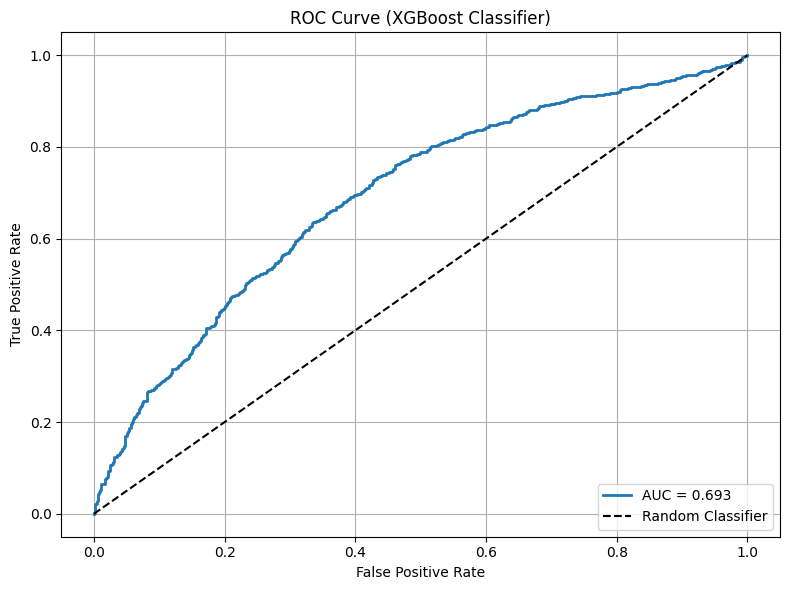

In [ ]:
# AUC with all features.

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (XGBoost Classifier)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

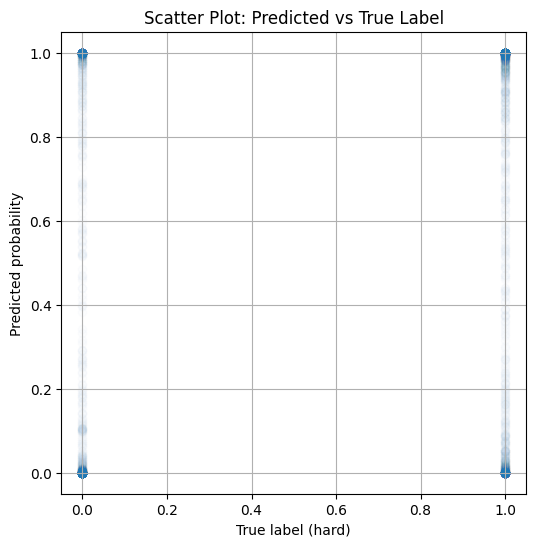

In [ ]:
import matplotlib.pyplot as plt
# the XGBoost model does slightly better in outputting predicted probabilities.
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_proba, alpha=1e-2)
plt.xlabel("True label (hard)")
plt.ylabel("Predicted probability")
plt.title("Scatter Plot: Predicted vs True Label")
plt.grid(True)
plt.show()

In [ ]:
import shap

explainer = shap.Explainer(model, X_train)     # TreeExplainer under the hood
shap_values = explainer(X_test)               # SHAP values for each sample

/dccstor/gma2/jhjenny9/envs/model_serve/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
question_embedding_shap = shap_values.values[:, :-7]
num_samples_shap = shap_values.values[:, -6]
question_length_shap = shap_values.values[:, -5]
method_maj_shap = shap_values.values[:, -4]
method_naive_shap = shap_values.values[:, -3]
method_weighted_shap = shap_values.values[:, -2]
method_beam_search_shap = shap_values.values[:, -1]  # Beam search method

# Summary statistics
print(f"Mean SHAP value for 'question embedding': {question_embedding_shap.mean():.4f}")
print(f"Mean SHAP value for 'num samples': {num_samples_shap.mean():.4f}")
print(f"Mean SHAP value for 'question length': {question_length_shap.mean():.4f}")
print(f"Mean SHAP value for 'method_maj': {method_maj_shap.mean():.4f}")
print(f"Mean SHAP value for 'method_naive': {method_naive_shap.mean():.4f}")
print(f"Mean SHAP value for 'method_weighted': {method_weighted_shap.mean():.4f}")
print(f"Mean SHAP value for 'method_beam_search': {method_beam_search_shap.mean():.4f}")

Mean SHAP value for 'question embedding': -0.0004
Mean SHAP value for 'num samples': 0.0034
Mean SHAP value for 'question length': -0.0140
Mean SHAP value for 'method_maj': -0.0279
Mean SHAP value for 'method_naive': 0.0297
Mean SHAP value for 'method_weighted': -0.0240
Mean SHAP value for 'method_beam_search': 0.0122


In [ ]:
# predict probability of positive class (correct answer) for test set.
# XGBoost Classifier.
# y_proba = model.predict_proba(X_test)[:, 1]
df_test['predicted_prob'] = softLabel_preds_numpy

In [ ]:
# df_train['predicted_prob'] = hardLabel_preds_numpy
# df_test['predicted_prob'] = hardLabel_preds_numpy # PyTorch MLP predictions from hard label.
# df_train['predicted_prob'] = y_proba_train # sklearn MLPClassifier predictions (hard label version)

In [ ]:
# there should be 23 different BoN configurations for each query in the test set.
df_test.groupby('sb_idx').size().reset_index(name='count')

,sb_idx,count
0,2,20
1,10,20
2,12,20
3,13,20
4,16,20
...,...,...
95,478,20
96,480,20
97,486,20
98,495,20


In [ ]:
df_test.head()

,question,score,completion_tokens,sb_idx,sl,N,question_length,token_count,time,method_beam_search,method_majority,method_naive,method_weighted,method,predicted_prob
0,"If $f(x) = \frac{3x-2}{x-2}$, what is the valu...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[432, 256, 460, 509, 505, 462, 437, 512, 360, ...",2,0.92,2,113,688,2.20,False,False,False,True,weighted,0.661000
1,What is the least positive integer multiple of...,"[0.86328125, 0.0708007812, 0.5546875, 0.878906...","[512, 316, 1032, 412, 609, 423, 354, 431, 595,...",10,0.14,2,99,828,3.23,False,False,False,True,weighted,0.169385
2,"The proper divisors of 12 are 1, 2, 3, 4 and 6...","[0.640625, 1.0, 0.99609375, 1.0, 0.1137695312,...","[176, 365, 285, 839, 427, 359, 355, 411, 300, ...",12,0.08,2,215,541,2.12,False,False,False,True,weighted,0.269709
3,The volume of the cylinder shown is $45\pi$ cu...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[277, 248, 237, 251, 221, 198, 152, 248, 282, ...",13,1.00,2,384,525,1.08,False,False,False,True,weighted,0.760470
4,Compute: $1-2+3-4+5- \dots +99-100$.,"[1.0, 1.0, 1.0, 1.0, 0.99609375, 1.0, 1.0, 0.9...","[152, 262, 236, 215, 178, 264, 226, 202, 239, ...",16,0.84,2,36,414,1.60,False,False,False,True,weighted,0.724593


In [ ]:
df_test_beam = df_test[df_test["method"] == "beam_search"]

In [ ]:
# get the average accuracy and token_count for each configuration of step-beam that was run.
config_summary_df = df_test.groupby(["N", "method"])[
    ["sl", "predicted_prob", "token_count", "time"] # accuracy keeps track of Pass@N (aka, percentage of correct answers).
].mean().reset_index()

In [ ]:
config_summary_df.head(20)

,N,method,sl,predicted_prob,token_count,time
0,2,beam_search,0.4048,0.544354,1295.12,5.8316
1,2,majority,0.4220,0.533100,972.13,2.9484
2,2,naive,0.5278,0.541155,972.13,3.0595
3,2,weighted,0.5278,0.541787,972.13,3.0595
4,4,beam_search,0.6381,0.555344,2648.84,7.5129
5,4,majority,0.5138,0.544166,1988.49,3.0719
6,4,naive,0.6062,0.552188,1988.49,3.2847
7,4,weighted,0.6052,0.552818,1988.49,3.2847
8,8,beam_search,0.7298,0.577094,7009.91,15.6604
9,8,majority,0.6000,0.566093,4007.45,3.8376


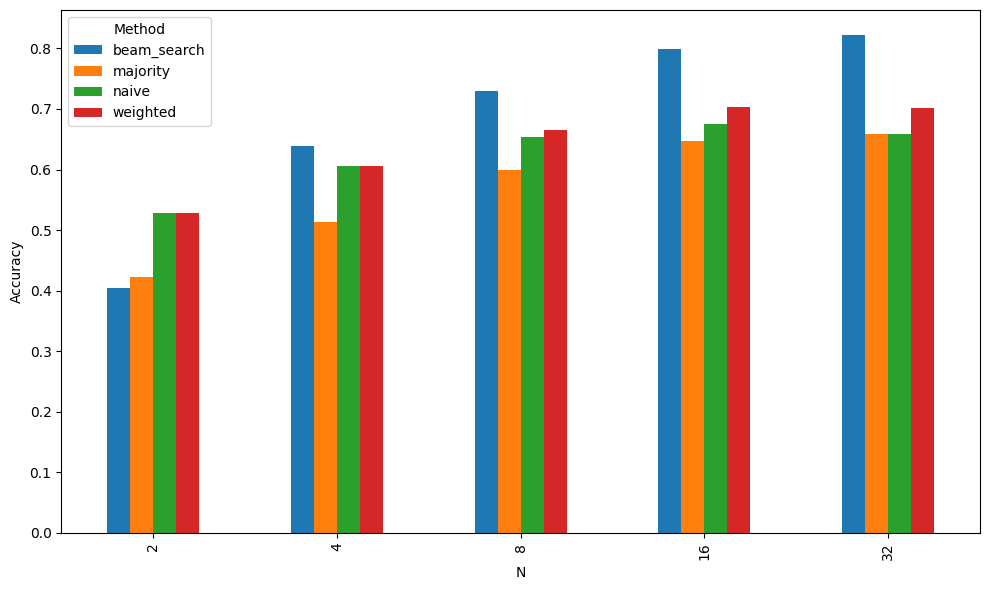

In [ ]:
pivot_df = config_summary_df.pivot(index="N", columns="method", values="sl")

# Plot
pivot_df.plot(kind="bar", figsize=(10, 6))

# plt.title("Accuracy by N")
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.legend(title="Method")
plt.tight_layout()
plt.show()

### Optimal-Utility Router

$$\text{Utility}(x, m) = \hat{a}_m(x) - \lambda \cdot \text{Cost}_m(x)$$

$$\text{Query-adaptive}(x, m) = \argmax_m \; \text{Utility}(x, m)

Input: A dataframe that contains rows for different settings (beam size, beam width, chunk size, etc.) and includes: an accuracy column, an avg_cot_token_count column (which is the cost), and a sb_idx column (which is the query).

A parameter, lambda, that controls how much the user is willing to tradeoff accuracy and cost.

For each group (i.e., all rows of the same query, or sb_idx):

It computes a utility value for each row:

$$\text{Utility}(x, m) = \hat{a}_m(x) - \lambda \cdot \text{Cost}_m(x)$$

It finds the row with the highest utility in that group.

Output:
A new DataFrame where each row corresponds to a query and contains:
the best utility found, the accuracy, and cost for that best-performing configuration.

In [ ]:
def compute_max_utility_pred(df, lambda_, c_metric):
    def get_max_utility(group): # verified correctness.
        group = group.copy()
        group["utility"] = group["predicted_prob"] - lambda_ * group[c_metric]
        idx_max = group["utility"].idxmax()
        # print("max utility index is: ", idx_max)
        return pd.Series({
            "max_utility": group.loc[idx_max, "utility"],
            "max_predicted_prob": group.loc[idx_max, "predicted_prob"],
            "max_sl": group.loc[idx_max, "sl"], # indicator that keeps track of whether the answer is correct.
            "max_cost": group.loc[idx_max, "token_count"],
            "max_time": group.loc[idx_max, "time"],
            "N": group.loc[idx_max, "N"],
            "method": group.loc[idx_max, "method"],
        })

    result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
    return result_df

In [ ]:
# filter for only method_beam_search.
df_test_beam = df_test[df_test["method"] == "beam_search"]

Selected questions: [ 59  69 379 430  32 116 372 442 495 480 377 383   2 212 177 499 224  44
 122 211 402 241 403 390 179]


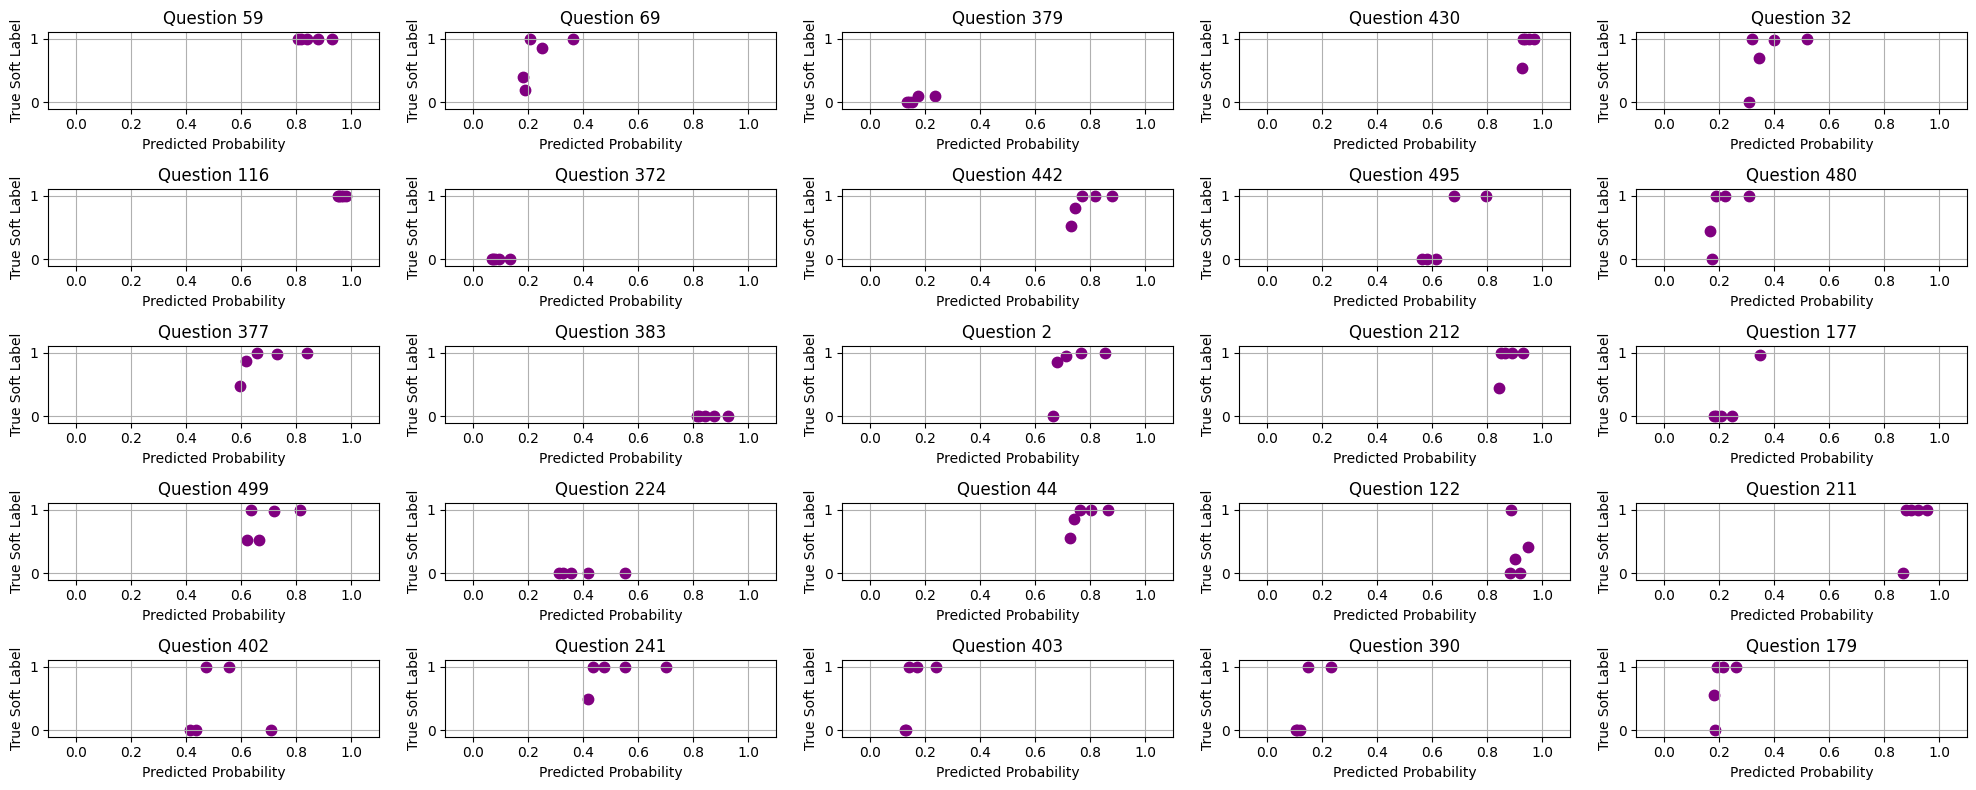

In [ ]:
# import matplotlib.pyplot as plt
question = df_test_beam[df_test_beam["sb_idx"] == 10]
# select columns N, indicator, predicted_prob.
question[["N", "sl", "predicted_prob"]]


# Randomly select 10 questions from the test set.
selected_questions = np.random.choice(df_test_beam["sb_idx"].unique(), 25, replace=False)
print(f"Selected questions: {selected_questions}")

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(5, 5, figsize=(20, 8))
axes = axes.flatten()  # Flatten to make indexing easier

# Create plots for each selected question
for i, question_idx in enumerate(selected_questions):
    # Get data for this question
    question = df_test_beam[df_test_beam["sb_idx"] == question_idx]
    
    # Create scatter plot
    axes[i].scatter(question["predicted_prob"], question["sl"], 
                    alpha=1, s=56, color="purple")
    axes[i].set_xlim(-0.1, 1.1)
    axes[i].set_ylim(-0.1, 1.1)
    axes[i].set_title(f"Question {question_idx}")
    axes[i].set_xlabel("Predicted Probability")
    axes[i].set_ylabel("True Soft Label")
    axes[i].grid(True)

plt.tight_layout()
plt.show()


Number of questions in test set: 100
Mean proportion correct across all questions: 0.6788
Std proportion correct across all questions: 0.3331


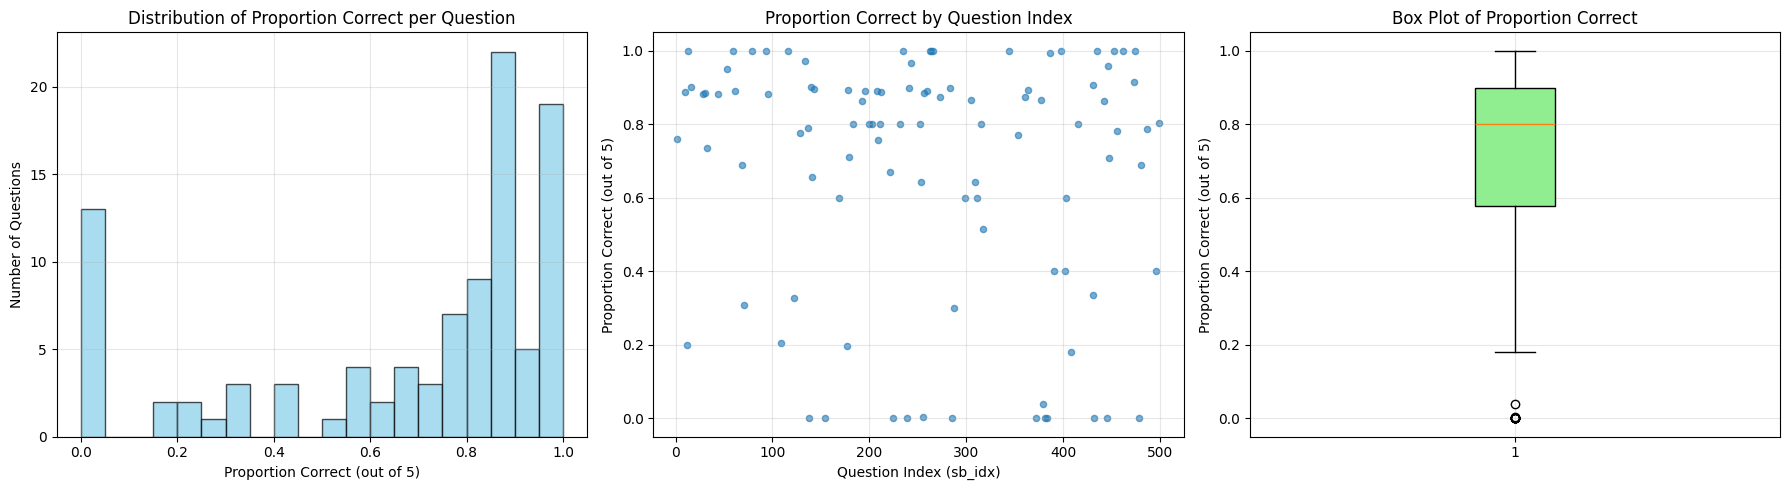


SUMMARY STATISTICS
Minimum proportion correct: 0.0000
25th percentile: 0.5785
Median proportion correct: 0.8000
75th percentile: 0.8980
Maximum proportion correct: 1.0000

BREAKDOWN BY PROPORTION CORRECT RANGES
Proportion 0.0-0.2: 15 questions (15.0%)
Proportion 0.2-0.4: 6 questions (6.0%)
Proportion 0.4-0.6: 4 questions (4.0%)
Proportion 0.6-0.8: 20 questions (20.0%)
Proportion 0.8-1.0: 40 questions (40.0%)

Questions with perfect scores (all 5 correct): 15
Questions with no correct answers: 11


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate proportion correct for each question in the test set
# Group by sb_idx and calculate the mean of indicator (which gives us the proportion correct)
proportion_correct = df_test_beam.groupby('sb_idx')['sl'].mean()

print(f"Number of questions in test set: {len(proportion_correct)}")
print(f"Mean proportion correct across all questions: {proportion_correct.mean():.4f}")
print(f"Std proportion correct across all questions: {proportion_correct.std():.4f}")

# Create the distribution plot
plt.figure(figsize=(18, 5))

# Create histogram
plt.subplot(1, 3, 1)
plt.hist(proportion_correct, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Proportion Correct (out of 5)')
plt.ylabel('Number of Questions')
plt.title('Distribution of Proportion Correct per Question')
plt.grid(True, alpha=0.3)

# Create scatter plot of proportion correct vs question index
plt.subplot(1, 3, 2)
plt.scatter(proportion_correct.index, proportion_correct.values, alpha=0.6, s=20)
plt.xlabel('Question Index (sb_idx)')
plt.ylabel('Proportion Correct (out of 5)')
plt.title('Proportion Correct by Question Index')
plt.grid(True, alpha=0.3)

# Create box plot
plt.subplot(1, 3, 3)
plt.boxplot(proportion_correct, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.ylabel('Proportion Correct (out of 5)')
plt.title('Box Plot of Proportion Correct')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"Minimum proportion correct: {proportion_correct.min():.4f}")
print(f"25th percentile: {proportion_correct.quantile(0.25):.4f}")
print(f"Median proportion correct: {proportion_correct.median():.4f}")
print(f"75th percentile: {proportion_correct.quantile(0.75):.4f}")
print(f"Maximum proportion correct: {proportion_correct.max():.4f}")

# Count questions by proportion correct ranges
print("\n" + "="*60)
print("BREAKDOWN BY PROPORTION CORRECT RANGES")
print("="*60)
ranges = [(0.0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
for low, high in ranges:
    count = ((proportion_correct >= low) & (proportion_correct < high)).sum()
    percentage = (count / len(proportion_correct)) * 100
    print(f"Proportion {low:.1f}-{high:.1f}: {count} questions ({percentage:.1f}%)")

# Questions with perfect scores (all 5 correct)
perfect_questions = proportion_correct[proportion_correct == 1.0]
print(f"\nQuestions with perfect scores (all 5 correct): {len(perfect_questions)}")

# Questions with no correct answers
zero_correct_questions = proportion_correct[proportion_correct == 0.0]
print(f"Questions with no correct answers: {len(zero_correct_questions)}")

#### When Lambda = 0.

In [ ]:
adaptive_router_this_lambda = compute_max_utility_pred(df_test, 9e-9, "token_count")
# view rows 10 through 20.
# daptive_router_0_lambda.iloc[0:60]
# view rows 10 through 20.

/tmp/ipykernel_679948/132001460.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()


Router is almost always routing between weighted and beam search, transitioning slowly weighted -> beam search as lambda increases.

/tmp/ipykernel_679948/2134181990.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_679948/2134181990.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_679948/2134181990.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping colum

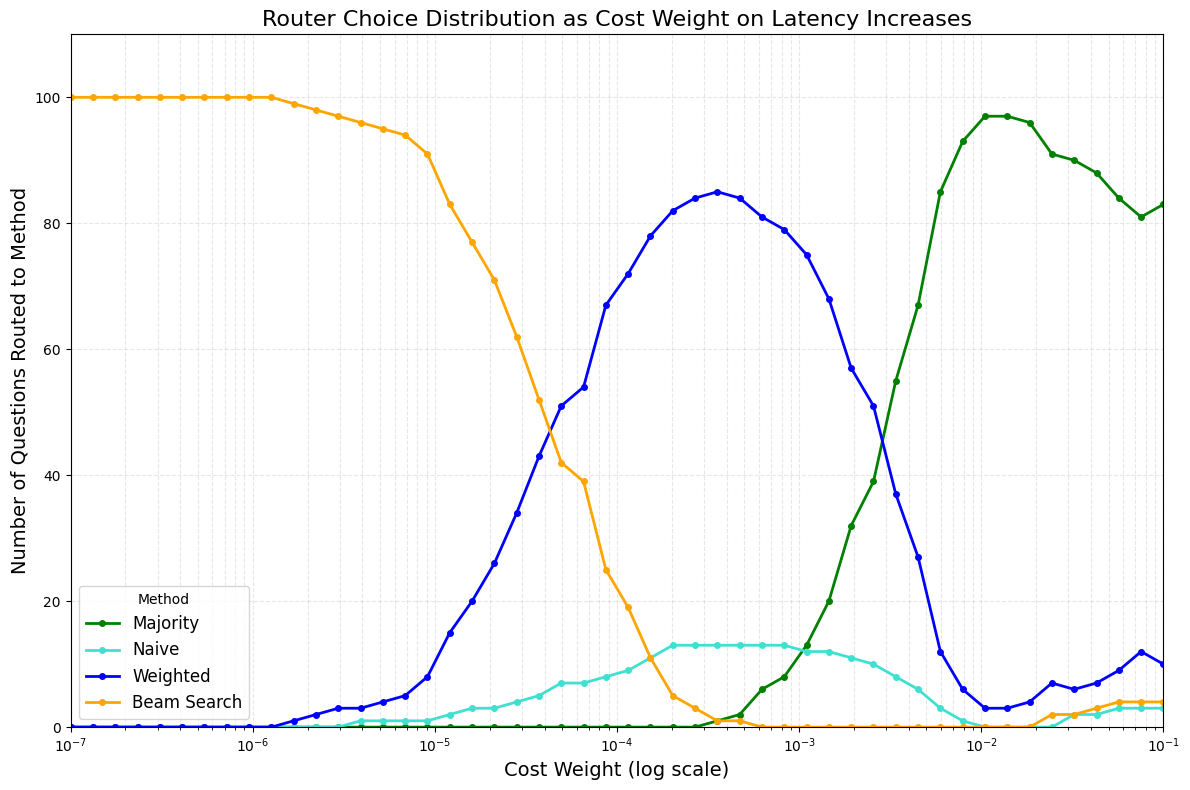

In [ ]:
# Plot progression of method distribution as lambda increases from 0 to 1
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Create a range of lambda values from 0 to 1
lambda_values = np.logspace(-7, -1, num=50) 

# Store results for each lambda
method_distributions = []

for lambda_val in lambda_values:
    # Compute optimal method selection for this lambda
    adaptive_router = compute_max_utility_pred(df_test, lambda_val, "token_count")
    
    # Count the frequency of each method
    method_counts = adaptive_router['method'].value_counts()
    
    # Store the distribution
    method_distributions.append({
        'lambda': lambda_val,
        'majority': method_counts.get('majority', 0),
        'naive': method_counts.get('naive', 0),
        'weighted': method_counts.get('weighted', 0),
        'beam_search': method_counts.get('beam_search', 0)
    })

# Convert to DataFrame
dist_df = pd.DataFrame(method_distributions)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each method as a line
methods = ['majority', 'naive', 'weighted', 'beam_search']
colors = ['green', 'turquoise', 'blue', 'orange']

for method, color in zip(methods, colors):
    plt.plot(dist_df['lambda'], dist_df[method], 
             label=method.replace('_', ' ').title(), 
             color=color, linewidth=2, marker='o', markersize=4)

plt.xscale('log')  # Set x-axis to log scale

# Optionally adjust axis limits to fit data better
plt.xlim(dist_df['lambda'].min(), dist_df['lambda'].max())
plt.ylim(0, dist_df[methods].values.max() * 1.1)

plt.xlabel('Cost Weight (log scale)', fontsize=14)
plt.ylabel('Number of Questions Routed to Method', fontsize=14)
plt.title('Router Choice Distribution as Cost Weight on Latency Increases', fontsize=16)
plt.legend(title='Method', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# this_lambda = 9e-5
# adaptive_router_this_lambda = compute_max_utility_pred(df_test, this_lambda)

# # Plot: Histogram of N values
# plt.figure(figsize=(8, 4))
# sns.countplot(data=adaptive_router_this_lambda, x="method", order=sorted(adaptive_router_this_lambda["method"].unique()), color="black")
# plt.title("Frequency of Chosen N Value")
# plt.xlabel("N")
# plt.ylabel("Count")
# plt.tight_layout()
# plt.show()

/tmp/ipykernel_2933550/2134181990.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_2933550/2134181990.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_2933550/2134181990.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping co

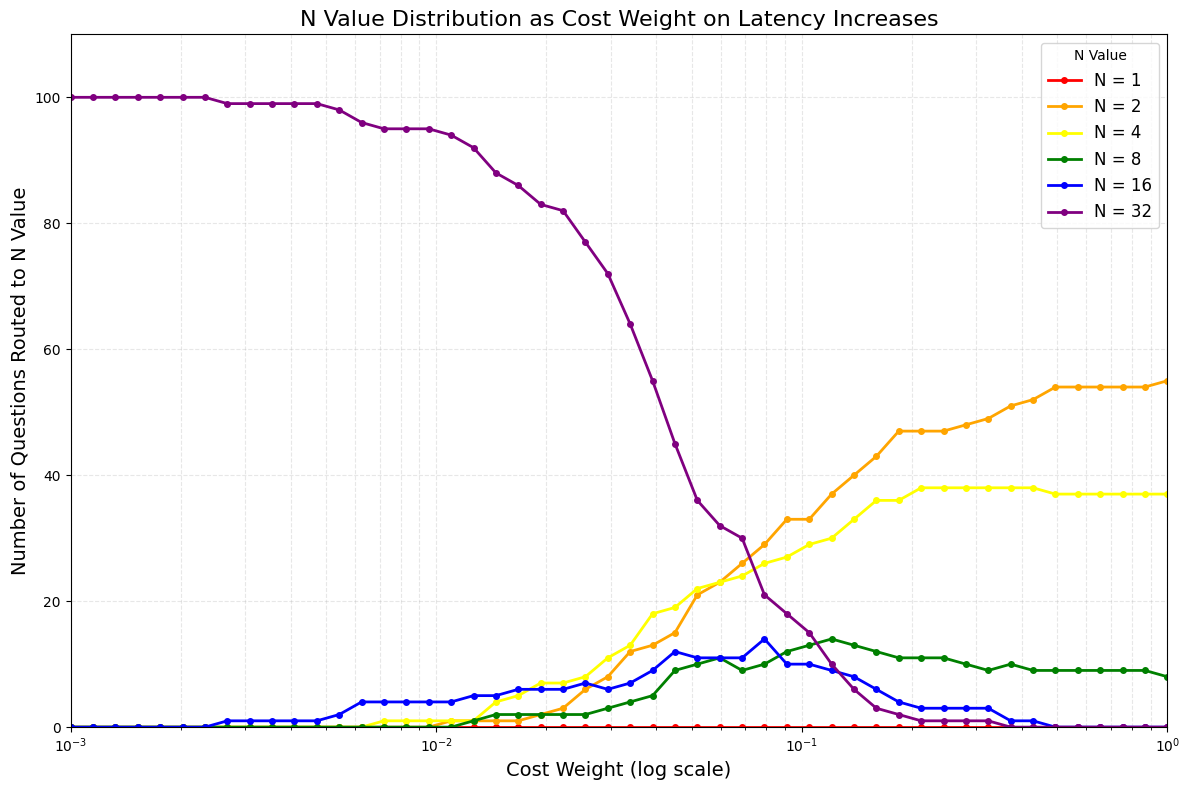

In [ ]:
# Create a range of lambda values from 0 to 1 (log scale for better visualization)
lambda_values = np.logspace(-3, -0, num=50) 

# Store results for each lambda
n_distributions = []

for lambda_val in lambda_values:
    # Compute optimal method selection for this lambda
    adaptive_router = compute_max_utility_pred(df_test, lambda_val, "token_count")
    
    # Count the frequency of each N value
    n_counts = adaptive_router['N'].value_counts()
    
    # Store the distribution
    n_distributions.append({
        'lambda': lambda_val,
        'N_1': n_counts.get(1.0, 0),
        'N_2': n_counts.get(2.0, 0),
        'N_4': n_counts.get(4.0, 0),
        'N_8': n_counts.get(8.0, 0),
        'N_16': n_counts.get(16.0, 0),
        'N_32': n_counts.get(32.0, 0)
    })

# Convert to DataFrame
dist_df = pd.DataFrame(n_distributions)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each N value as a line
n_values = ['N_1', 'N_2', 'N_4', 'N_8', 'N_16', 'N_32']
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

for n_val, color in zip(n_values, colors):
    plt.plot(dist_df['lambda'], dist_df[n_val], 
                label=n_val.replace('_', ' = '), 
                color=color, linewidth=2, marker='o', markersize=4)

plt.xscale('log')  # Set x-axis to log scale

# Optionally adjust axis limits to fit data better
plt.xlim(dist_df['lambda'].min(), dist_df['lambda'].max())
plt.ylim(0, dist_df[n_values].values.max() * 1.1)

plt.xlabel('Cost Weight (log scale)', fontsize=14)
plt.ylabel('Number of Questions Routed to N Value', fontsize=14)
plt.title('N Value Distribution as Cost Weight on Latency Increases', fontsize=16)
plt.legend(title='N Value', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

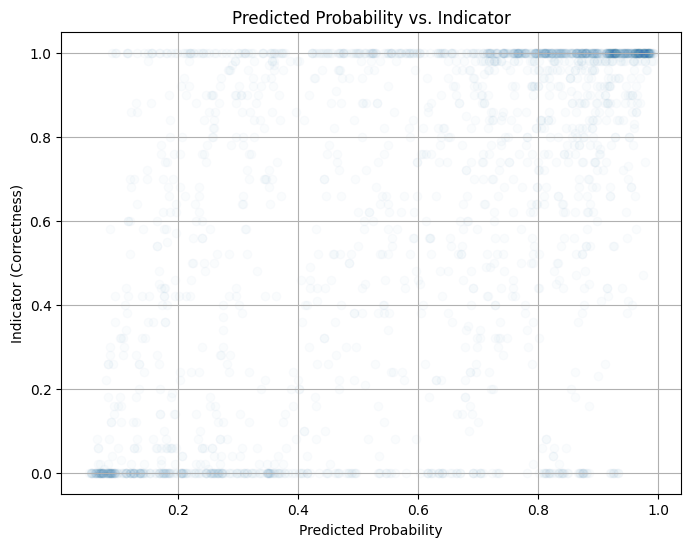

In [ ]:
df_test.head()
# create a scatter plot of predicted probability vs. indicator.
plt.figure(figsize=(8, 6))
plt.scatter(df_test["predicted_prob"], df_test["sl"], alpha=0.02)
plt.xlabel("Predicted Probability")
plt.ylabel("Indicator (Correctness)")
plt.title("Predicted Probability vs. Indicator")
plt.grid(True)
plt.show()

/tmp/ipykernel_679948/350233631.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration = df_test.groupby("bin").agg(


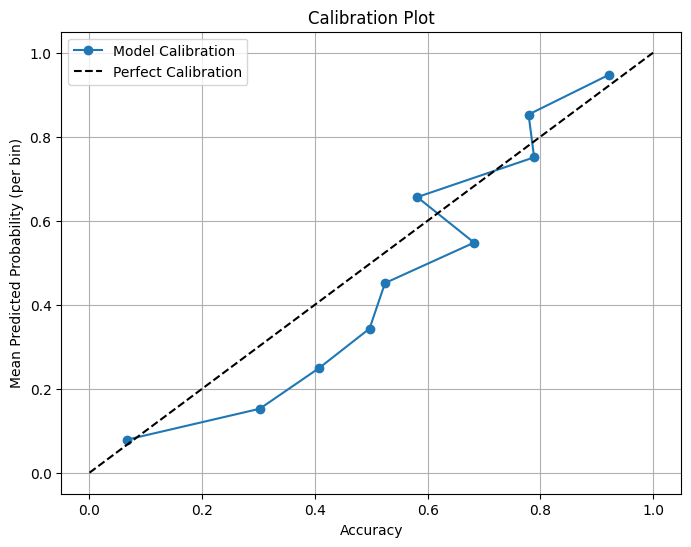

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define bin edges and assign each predicted_prob to a bin
num_bins = 10
df_test["bin"] = pd.cut(df_test["predicted_prob"], bins=np.linspace(0, 1, num_bins + 1), include_lowest=True)

# Group by bins and compute average predicted prob and accuracy
calibration = df_test.groupby("bin").agg(
    avg_pred_prob=("predicted_prob", "mean"),
    accuracy=("sl", "mean"),
    count=("sl", "count")
).dropna()

# Plot calibration curve with flipped axes
plt.figure(figsize=(8, 6))
plt.plot(calibration["accuracy"], calibration["avg_pred_prob"], marker='o', label="Model Calibration")
plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
plt.xlabel("Accuracy")
plt.ylabel("Mean Predicted Probability (per bin)")
plt.title("Calibration Plot")
plt.grid(True)
plt.legend()
plt.show()


Top 10 Questions with Biggest Prediction Mistakes:

Question 134 (Error: 0.9475):
Question: Let $F_1 = (10,2)$ and $F_ 2= (-16,2).$  Then the set of points $P$ such that
\[|PF_1 - PF_2| = 24\]form a hyperbola.  The equation of this hyperbola can be written as
\[\frac{(x - h)^2}{a^2} - \frac{...

All configurations for this question:
------------------------------------------------------------
  weighted (N=2): Predicted=0.0501, Actual=0.6000, Error=0.5499
  naive (N=2): Predicted=0.0497, Actual=0.6000, Error=0.5503
  weighted (N=4): Predicted=0.0524, Actual=0.6800, Error=0.6276
  naive (N=4): Predicted=0.0519, Actual=0.7000, Error=0.6481
  weighted (N=8): Predicted=0.0575, Actual=0.8600, Error=0.8025
  naive (N=8): Predicted=0.0570, Actual=0.8800, Error=0.8230
  majority (N=8): Predicted=0.0528, Actual=0.7000, Error=0.6472
  weighted (N=16): Predicted=0.0703, Actual=1.0000, Error=0.9297
  naive (N=16): Predicted=0.0696, Actual=0.8800, Error=0.8104
  majority (N=16): Predicted=0.0645, A

/dccstor/gma2/jhjenny9/search-and-learn/scripts/analyze_prediction_mistakes.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['sl_bin'] = pd.cut(df_test['sl'], bins=sl_bins, labels=False)
/dccstor/gma2/jhjenny9/search-and-learn/scripts/analyze_prediction_mistakes.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['ql_bin'] = pd.cut(df_test['question_length'], bins=ql_bins, labels=False)
/dccstor/gma2/jhjenny9/search-and-learn/scripts/analyze_prediction_mistakes.py:157: SettingWithCopy

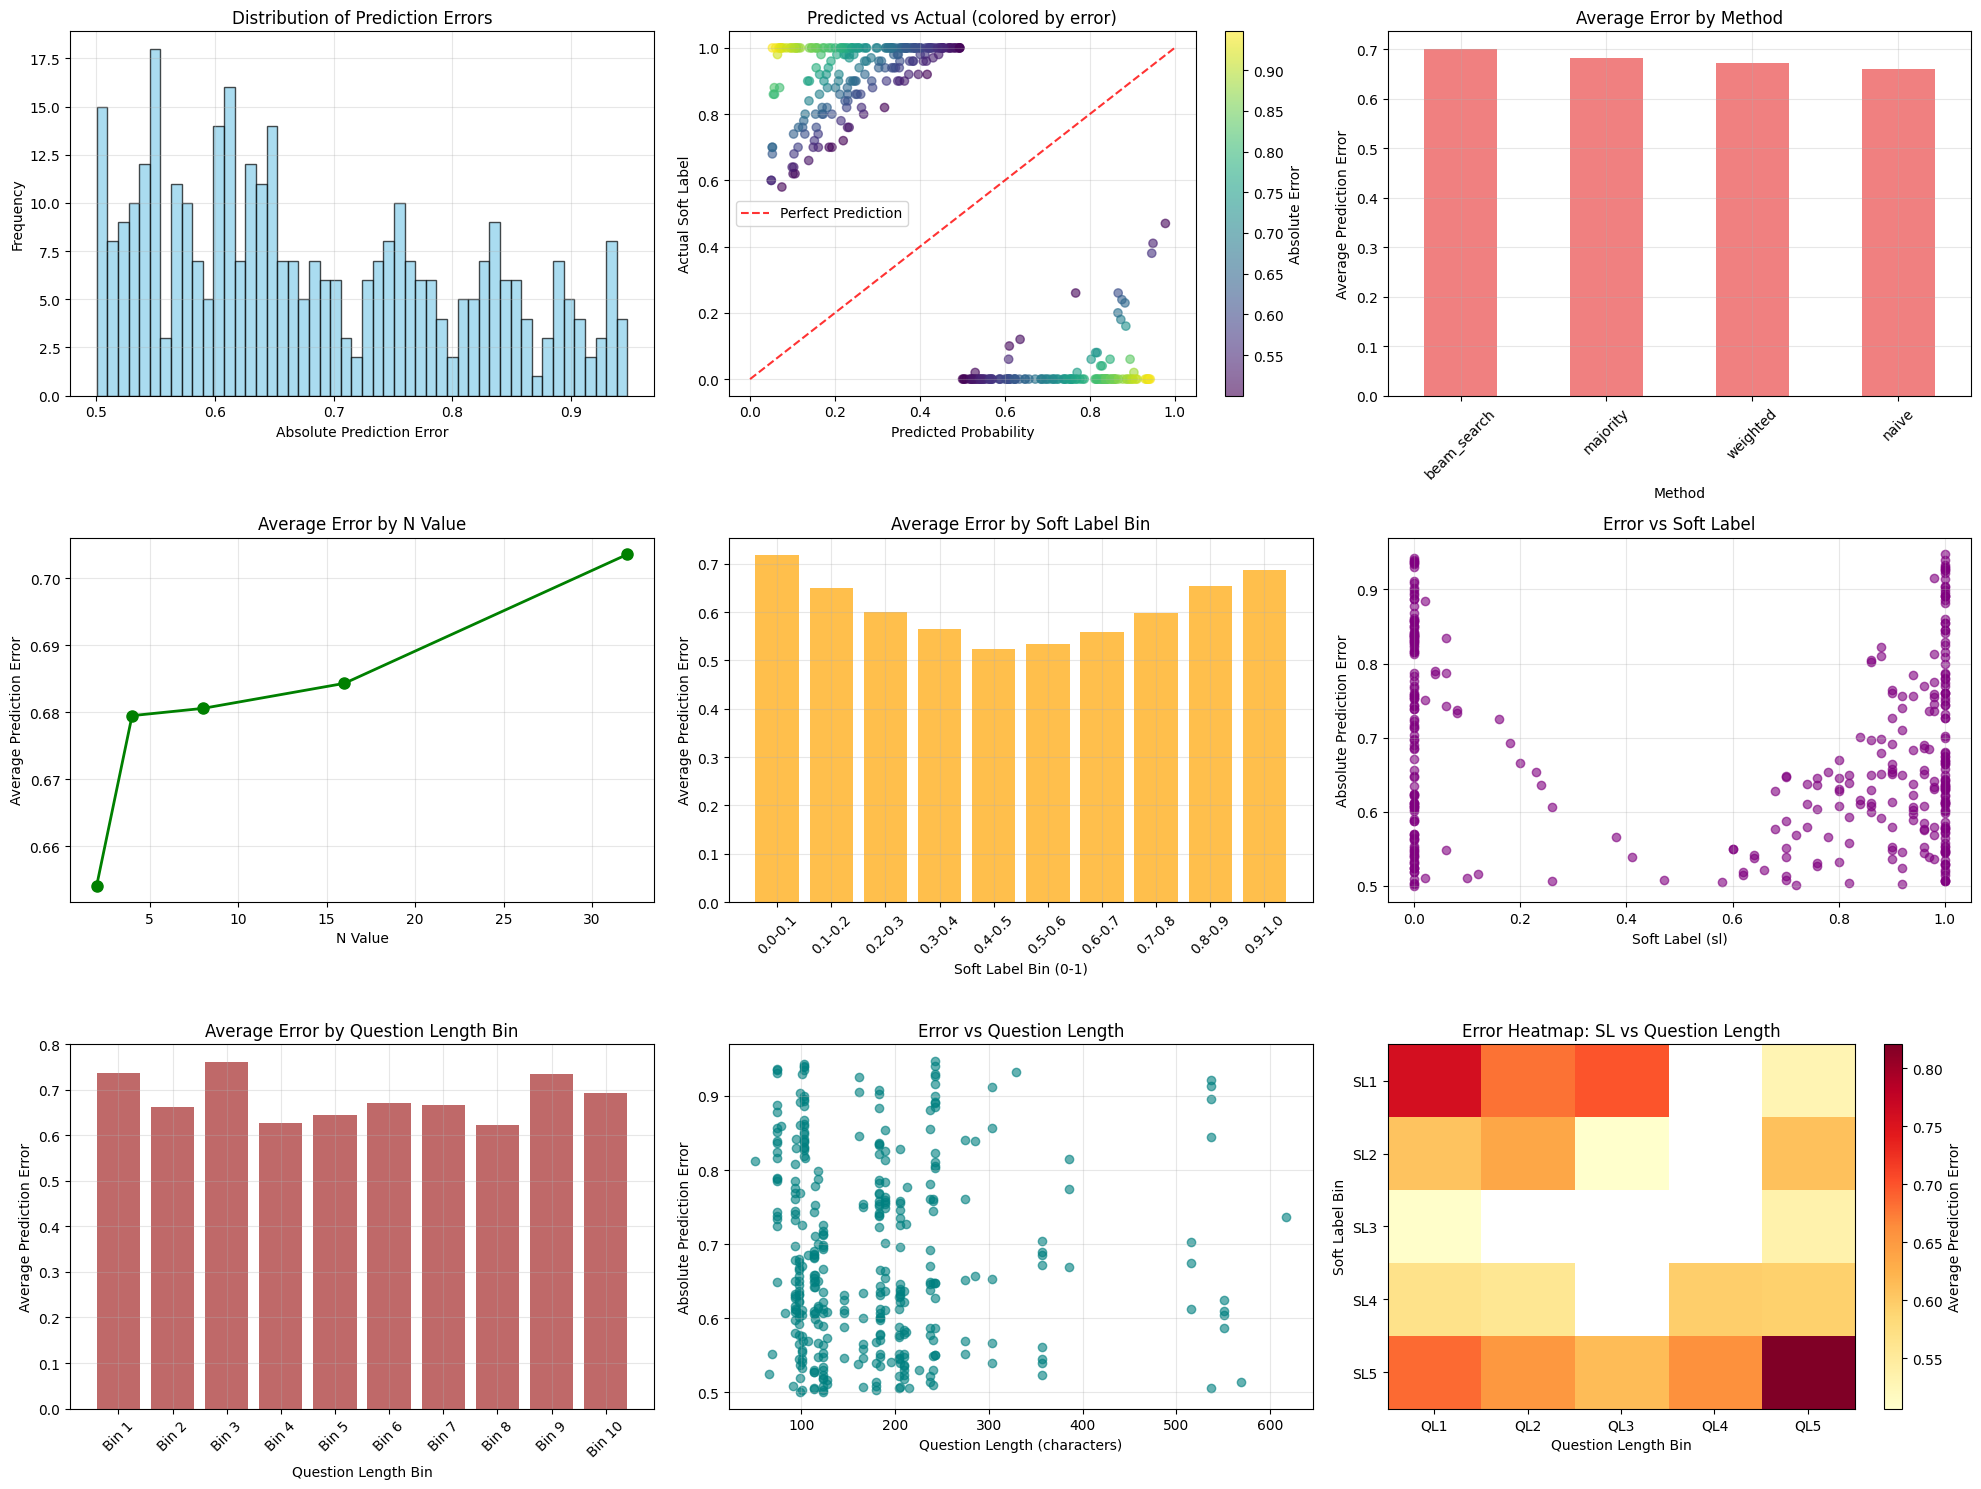


SUMMARY STATISTICS
Overall Statistics:
  Mean prediction error: 0.6825
  Median prediction error: 0.6507
  Std prediction error: 0.1258
  Max prediction error: 0.9475

Error by Soft Label Range:
  SL 0-0.2: Mean error = 0.7178 (n=132)
  SL 0.2-0.4: Mean error = 0.6058 (n=6)
  SL 0.4-0.6: Mean error = 0.5174 (n=3)
  SL 0.6-0.8: Mean error = 0.5711 (n=28)
  SL 0.8-1.0: Mean error = 0.6534 (n=84)

Error by Question Length Quartiles:
  Q1 (≤103 chars): Mean error = 0.7272
  Q2 (≤164 chars): Mean error = 0.6878
  Q3 (≤209 chars): Mean error = 0.6766
  Q4 (> 209 chars): Mean error = 0.7023

ERROR ANALYSIS SUMMARY:

Average Error by Method:
  beam_search: 0.7013
  majority: 0.6825
  weighted: 0.6727
  naive: 0.6607

Average Error by N Value:
  N=2: 0.6542
  N=4: 0.6795
  N=8: 0.6806
  N=16: 0.6843
  N=32: 0.7036

Overall Error Statistics:
  Mean Error: 0.6825
  Median Error: 0.6507
  Std Error: 0.1258
  Max Error: 0.9475

Questions with errors > 95th percentile (0.9083): 8


In [ ]:
import importlib
import analyze_prediction_mistakes
importlib.reload(analyze_prediction_mistakes)

worst_predictions, question_errors = analyze_prediction_mistakes.analyze_prediction_mistakes(df_test, top_k=10)


Detailed Analysis for Question 383:
Question: For what values of $x$ is it true that $x^2 - 5x - 4 \le 10$? Express your answer in interval notation.

All configurations:
------------------------------------------------------------
  weighted (N=2):
    Predicted: 0.8313
    Actual: 0.0000
    Error: 0.8313

  naive (N=2):
    Predicted: 0.8274
    Actual: 0.0000
    Error: 0.8274

  majority (N=2):
    Predicted: 0.8184
    Actual: 0.0000
    Error: 0.8184

  weighted (N=4):
    Predicted: 0.8422
    Actual: 0.0000
    Error: 0.8422

  naive (N=4):
    Predicted: 0.8385
    Actual: 0.0000
    Error: 0.8385

  majority (N=4):
    Predicted: 0.8300
    Actual: 0.0000
    Error: 0.8300

  weighted (N=8):
    Predicted: 0.8621
    Actual: 0.0000
    Error: 0.8621

  naive (N=8):
    Predicted: 0.8589
    Actual: 0.0000
    Error: 0.8589

  majority (N=8):
    Predicted: 0.8512
    Actual: 0.0000
    Error: 0.8512

  weighted (N=16):
    Predicted: 0.8953
    Actual: 0.0000
    Error: 0.8

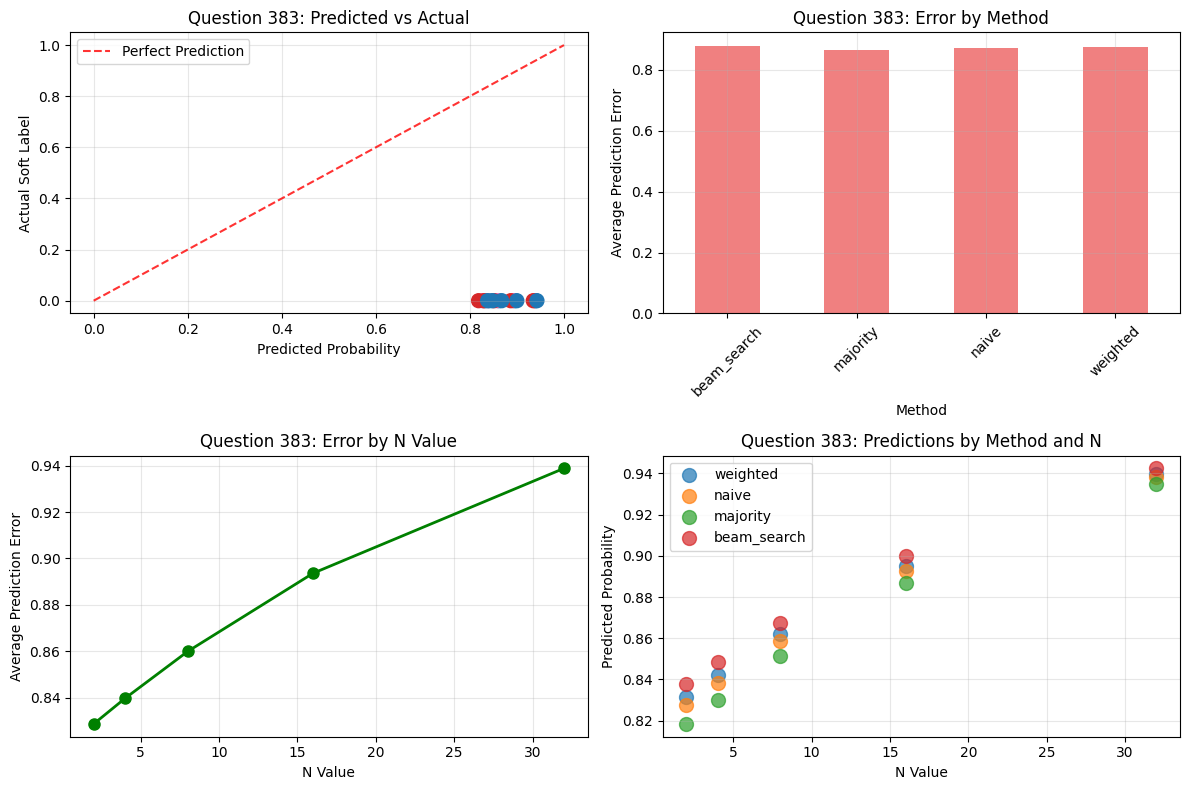

In [ ]:
analyze_prediction_mistakes.analyze_specific_question(df_test, question_idx=worst_predictions.iloc[1]['sb_idx']) 

In [ ]:
worst_predictions

,sb_idx,prediction_error,question
10,134,0.947473,"Let $F_1 = (10,2)$ and $F_ 2= (-16,2).$ Then ..."
45,383,0.942481,For what values of $x$ is it true that $x^2 - ...
5,71,0.936698,The binary number $10101001110_{2}$ is equal t...
7,109,0.932945,Find the degree measure of the least positive ...
51,431,0.930088,Let\n\[f(x) = (\arccos x)^2 + (\arcsin x)^2.\]...
48,403,0.925923,How many of the same digits are found in the b...
55,473,0.921614,"Below is a magic square, meaning that the sum ..."
8,122,0.911450,"Daniel works at an electronics store, and he c..."
49,408,0.908179,A reflection takes $\begin{pmatrix} 5 \\ 0 \en...
1,10,0.903626,What is the least positive integer multiple of...


In [ ]:
# inspect the questions and preds of the worst predictions.
import json
import pandas as pd
import numpy as np

# Load JSONL data
jsonl_file = "/dccstor/gma2/jhjenny9/search-and-learn/data/Qwen/Qwen2.5-1.5B-Instruct/parallel_best_of_32/best_of_n_completions.jsonl"

def load_jsonl_data(file_path):
    """Load data from JSONL file."""
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

print("Loading JSONL data...")
jsonl_data = load_jsonl_data(jsonl_file)
print(f"Loaded {len(jsonl_data)} entries from JSONL file")

# Calculate absolute prediction error for each row
df_test['prediction_error'] = np.abs(df_test['predicted_prob'] - df_test['sl'])

# Group by question (sb_idx) and find the maximum error for each question
question_errors = df_test.groupby('sb_idx')['prediction_error'].max().reset_index()
question_errors = question_errors.merge(
    df_test[['sb_idx', 'question']].drop_duplicates(), 
    on='sb_idx', 
    how='left'
)

# Sort by prediction error (descending) to get worst predictions
worst_predictions = question_errors.sort_values('prediction_error', ascending=False).head(50)

print("Top 10 Questions with Biggest Prediction Mistakes:")
print("=" * 80)
for i, (_, row) in enumerate(worst_predictions.iterrows()):
    print(f"{i+1}. Question {row['sb_idx']}: Error = {row['prediction_error']:.4f}")
    print(f"   Question: {row['question'][:100]}...")
    print()

# Function to analyze a specific question in detail
def analyze_specific_question(question_idx):
    """Analyze a specific question in detail."""
    print(f"\n{'='*80}")
    print(f"ANALYZING QUESTION {question_idx}")
    print(f"{'='*80}")
    
    # Get all configurations for this question
    question_data = df_test[df_test['sb_idx'] == question_idx]
    
    print(f"Question: {question_data['question'].iloc[0]}")
    print(f"Predicted Probability: {question_data['predicted_prob'].iloc[0]:.4f}")
    print(f"Prediction Error: {abs(question_data['predicted_prob'].iloc[0] - question_data['sl'].iloc[0]):.4f}")
    
    print(f"\nConfigurations for this question:")
    for _, row in question_data.iterrows():
        print(f"  N={row['N']}, Method={row['method']}: predicted={row['predicted_prob']:.4f}, sl={row['sl']:.4f}")
    
    # Find corresponding data in JSONL file
    jsonl_entry = None
    for idx, entry in enumerate(jsonl_data):
        if idx == question_idx:
            jsonl_entry = entry
            break
    
    if jsonl_entry:
        print(f"\nJSONL Data for Question {question_idx}:")
        print(f"Problem: {jsonl_entry.get('problem', 'N/A')}")
        print(f"Solution: {jsonl_entry.get('solution', 'N/A')}")
        print(f"Answer: {jsonl_entry.get('answer', 'N/A')}")
        print(f"Subject: {jsonl_entry.get('subject', 'N/A')}")
        print(f"Level: {jsonl_entry.get('level', 'N/A')}")
        
        # Analyze prediction methods for different N values
        print(f"\n{'='*60}")
        print("PREDICTION METHODS ANALYSIS")
        print(f"{'='*60}")
        
        # Check for different N values (1, 2, 4, 8, 16, 32)
        n_values = [1, 2, 4, 8, 16, 32]
        methods = ['weighted', 'maj', 'naive']
        
        for n in n_values:
            print(f"\nN = {n}:")
            for method in methods:
                pred_key = f"pred_{method}@{n}"
                indicator_key = f"indicator_{method}@{n}"
                correctness_key = f"correctness@{n}"
                
                pred_value = jsonl_entry.get(pred_key, 'N/A')
                indicator_value = jsonl_entry.get(indicator_key, 'N/A')
                correctness_values = jsonl_entry.get(correctness_key, [])
                
                print(f"  {method.upper()}:")
                print(f"    Prediction: {pred_value}")
                print(f"    Indicator: {indicator_value}")
                if correctness_values:
                    correct_count = sum(correctness_values)
                    total_count = len(correctness_values)
                    accuracy = correct_count / total_count if total_count > 0 else 0
                    print(f"    Correctness: {correct_count}/{total_count} ({accuracy:.3f})")
                else:
                    print(f"    Correctness: N/A")
        
        # Show some completions
        completions = jsonl_entry.get('completions', [])
        if completions:
            print(f"\nSample Completions (first 3):")
            for i, completion in enumerate(completions[:3]):
                print(f"  Completion {i+1}: {completion[:200]}...")
        
        # Show scores
        scores = jsonl_entry.get('scores', [])
        if scores:
            print(f"\nSample Scores (first 3):")
            for i, score in enumerate(scores[:3]):
                print(f"  Score {i+1}: {score[:5]}...")
        
        # Analyze verifier consistency
        print(f"\n{'='*60}")
        print("VERIFIER CONSISTENCY ANALYSIS")
        print(f"{'='*60}")
        
        # Check if different methods give consistent results
        for n in n_values:
            pred_weighted = jsonl_entry.get(f"pred_weighted@{n}", None)
            pred_maj = jsonl_entry.get(f"pred_maj@{n}", None)
            pred_naive = jsonl_entry.get(f"pred_naive@{n}", None)
            
            if pred_weighted and pred_maj and pred_naive:
                methods_agree = (pred_weighted == pred_maj == pred_naive)
                print(f"N={n}: Methods agree = {methods_agree}")
                if not methods_agree:
                    print(f"  Weighted: {pred_weighted}")
                    print(f"  Majority: {pred_maj}")
                    print(f"  Naive: {pred_naive}")
        
    else:
        print(f"\nNo JSONL data found for question {question_idx}")

# Analyze the top 10 worst predictions
num_to_analyze = min(40, len(worst_predictions))
for i in range(10, num_to_analyze):
    question_idx = worst_predictions.iloc[i]['sb_idx']
    print(f"\nAnalyzing the {i+1} worst prediction (Question {question_idx}):")
    analyze_specific_question(question_idx)

print(f"\n{'='*80}")
print("VERIFIER NOISE ANALYSIS")
print(f"{'='*80}")
print("Based on the analysis above, consider the following questions:")
print("1. Are the model's predictions reasonable given the question difficulty?")
print("2. Are the soft labels (sl) consistent across different N values and methods?")
print("3. Do the generated completions match the expected quality based on the scores?")
print("4. Are there cases where the verifier seems to be inconsistent or overly harsh/lenient?")
print("5. Do the worst predictions correspond to particularly difficult or ambiguous questions?") 


Loading JSONL data...
Loaded 500 entries from JSONL file
Top 10 Questions with Biggest Prediction Mistakes:
1. Question 134: Error = 0.9475
   Question: Let $F_1 = (10,2)$ and $F_ 2= (-16,2).$  Then the set of points $P$ such that
\[|PF_1 - PF_2| = 24\]...

2. Question 383: Error = 0.9425
   Question: For what values of $x$ is it true that $x^2 - 5x - 4 \le 10$? Express your answer in interval notati...

3. Question 71: Error = 0.9367
   Question: The binary number $10101001110_{2}$ is equal to what number in base eight?...

4. Question 109: Error = 0.9329
   Question: Find the degree measure of the least positive angle $\theta$ for which
\[\tan \theta = \frac{\cos 5^...

5. Question 431: Error = 0.9301
   Question: Let
\[f(x) = (\arccos x)^2 + (\arcsin x)^2.\]Find the range of $f(x).$  All functions are in radians...

6. Question 403: Error = 0.9259
   Question: How many of the same digits are found in the base 7 and base 8 representations of $629_{10}$? For ex...

7. Question 473: Er

In [ ]:
# Sweep over lambda values
lambda_list = np.logspace(-50, -1, num=200) 

In [ ]:
results = []

for lambda_value in lambda_list:
    adaptive_router = compute_max_utility_pred(df_test, lambda_value, "token_count")
    average_accuracy = adaptive_router["max_sl"].mean() # accuracy as a percentage of questions (out of all questions in the test set) answered correctly.
    average_cost = adaptive_router["max_cost"].mean()
    average_time = adaptive_router["max_time"].mean()
    average_predicted_prob = adaptive_router["max_predicted_prob"].mean()
    
    results.append({
        "lambda": lambda_value,
        "sl": average_accuracy,
        "token_count": average_cost,
        "predicted_prob": average_predicted_prob,
        "time": average_time,
    })

# Convert to DataFrame
query_adaptive_df = pd.DataFrame(results)
# oracle_df = pd.DataFrame(results)

/tmp/ipykernel_679948/132001460.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_679948/132001460.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("sb_idx").apply(get_max_utility).reset_index()
/tmp/ipykernel_679948/132001460.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns.

In [ ]:
query_adaptive_df["method"] = "adaptive"
query_adaptive_df.head()
# oracle_df['method'] = 'oracle'
# oracle_df.head()

,lambda,sl,token_count,predicted_prob,time,method
0,1.000000e-50,0.8222,31613.52,0.69707,54.7503,adaptive
1,1.762914e-50,0.8222,31613.52,0.69707,54.7503,adaptive
2,3.107866e-50,0.8222,31613.52,0.69707,54.7503,adaptive
3,5.478901e-50,0.8222,31613.52,0.69707,54.7503,adaptive
4,9.658832e-50,0.8222,31613.52,0.69707,54.7503,adaptive


In [ ]:
# rename column indicator to accuracy.
config_summary_df

,N,method,sl,predicted_prob,token_count,time
0,2,beam_search,0.4048,0.544354,1295.12,5.8316
1,2,majority,0.4220,0.533100,972.13,2.9484
2,2,naive,0.5278,0.541155,972.13,3.0595
3,2,weighted,0.5278,0.541787,972.13,3.0595
4,4,beam_search,0.6381,0.555344,2648.84,7.5129
5,4,majority,0.5138,0.544166,1988.49,3.0719
6,4,naive,0.6062,0.552188,1988.49,3.2847
7,4,weighted,0.6052,0.552818,1988.49,3.2847
8,8,beam_search,0.7298,0.577094,7009.91,15.6604
9,8,majority,0.6000,0.566093,4007.45,3.8376


In [ ]:
### TESTING DF
# Pivot for plotting
pivot_df = config_summary_df_test.pivot(index="N", columns="method", values="sl")

# Plot
pivot_df.plot(kind="bar", figsize=(10, 6))

plt.title("MV, BoN, Weighted BoN - Accuracy by N")
plt.xlabel("N")
plt.ylabel("Accuracy")
plt.legend(title="Method")
plt.tight_layout()
plt.show()

In [ ]:
# outer join on the shared columns ("accuracy", "avg_cot_token_count")
query_optimal_static_df = pd.merge(
    query_adaptive_df,
    config_summary_df,
    on=["sl", "token_count", "time", "method", "predicted_prob"],
    how="outer"
)
query_optimal_static_df.head()
# change NaN to -1 for plotting purposes.
query_optimal_static_df = query_optimal_static_df.fillna(-1)

In [ ]:
query_optimal_static_df

,lambda,sl,token_count,predicted_prob,time,method,N
0,-1.000000e+00,0.4048,1295.12,0.544354,5.8316,beam_search,2.0
1,-1.000000e+00,0.4220,972.13,0.533100,2.9484,majority,2.0
2,6.294989e-05,0.4910,933.86,0.543159,3.4642,adaptive,-1.0
3,1.109752e-04,0.4924,929.68,0.542856,3.4819,adaptive,-1.0
4,1.956398e-04,0.4938,928.46,0.542672,3.4579,adaptive,-1.0
...,...,...,...,...,...,...,...
215,4.247572e-10,0.8222,31613.52,0.697070,54.7503,adaptive,-1.0
216,7.488104e-10,0.8222,31613.52,0.697070,54.7503,adaptive,-1.0
217,1.320088e-09,0.8222,31613.52,0.697070,54.7503,adaptive,-1.0
218,2.327202e-09,0.8222,31613.52,0.697070,54.7503,adaptive,-1.0


Join the Oracle.

In [ ]:
query_optimal_static_df = pd.merge(
    query_optimal_static_df,
    oracle_df,
    on=["lambda", "sl", "token_count", "predicted_prob", "time", "method"],
    how="outer"
)

In [ ]:
# Replace NaN values with -1 for plotting purposes
query_optimal_static_df = query_optimal_static_df.fillna(-1)

# Display the merged DataFrame
query_optimal_static_df

,lambda,sl,token_count,predicted_prob,time,method,N
0,-1.000000,0.4048,1295.12,0.549286,5.8316,beam_search,2.0
1,-1.000000,0.4220,972.13,0.534820,2.9484,majority,2.0
2,-1.000000,0.5138,1988.49,0.545988,3.0719,majority,4.0
3,-1.000000,0.5278,972.13,0.540454,3.0595,naive,2.0
4,-1.000000,0.5278,972.13,0.542810,3.0595,weighted,2.0
...,...,...,...,...,...,...,...
415,0.032176,0.5064,927.96,0.544582,3.4110,oracle,-1.0
416,0.056724,0.5060,927.96,0.544709,3.4133,adaptive,-1.0
417,0.056724,0.5064,927.96,0.544582,3.4110,oracle,-1.0
418,0.100000,0.5060,927.96,0.544709,3.4133,adaptive,-1.0


In [ ]:
# arrange in descending order of sl.
query_optimal_static_df.sort_values(by="sl", ascending=True)

,lambda,sl,token_count,predicted_prob,time,method,N
0,-1.000000e+00,0.4048,1295.12,0.544354,5.8316,beam_search,2.0
1,-1.000000e+00,0.4220,972.13,0.533100,2.9484,majority,2.0
2,-1.000000e+00,0.5138,1988.49,0.544166,3.0719,majority,4.0
3,-1.000000e+00,0.5278,972.13,0.541155,3.0595,naive,2.0
4,-1.000000e+00,0.5278,972.13,0.541787,3.0595,weighted,2.0
...,...,...,...,...,...,...,...
101,1.047371e-35,0.8222,31613.52,0.697070,54.7503,adaptive,-1.0
102,1.846425e-35,0.8222,31613.52,0.697070,54.7503,adaptive,-1.0
103,3.255089e-35,0.8222,31613.52,0.697070,54.7503,adaptive,-1.0
105,1.011638e-34,0.8222,31613.52,0.697070,54.7503,adaptive,-1.0


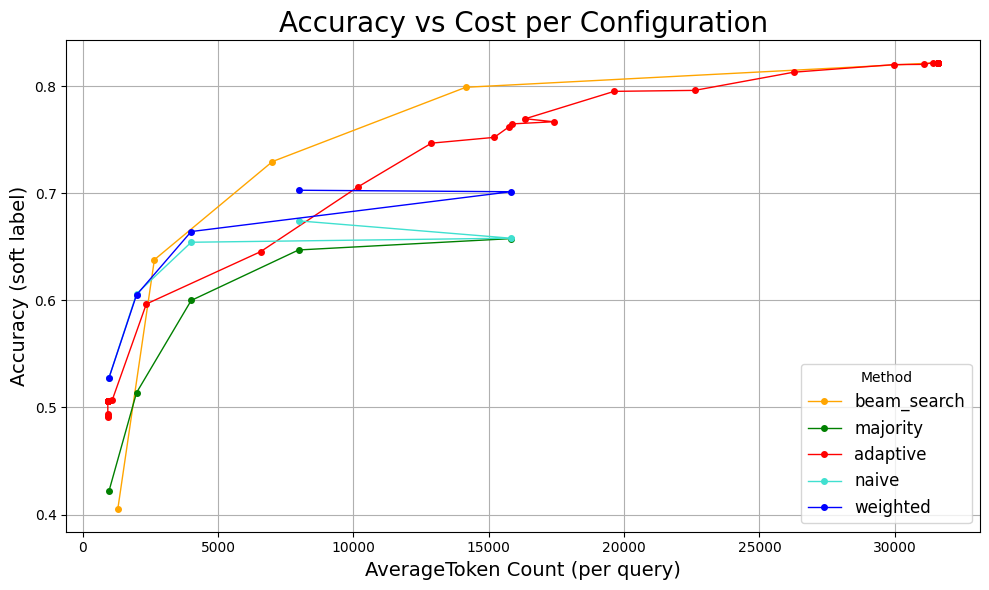

In [ ]:
# Assign unique colors for each method
method_colors = {
    "majority": "green",
    "naive": "turquoise",
    "weighted": "blue",
    "beam_search": "orange",
    "adaptive": "red"  # Query-adaptive router
    # "oracle": "gray"  # Oracle router
}

# Create a figure
plt.figure(figsize=(10, 6))

# Iterate over each method and plot its points and connecting lines
for method in query_optimal_static_df["method"].unique():
    method_df = query_optimal_static_df[query_optimal_static_df["method"] == method]
    color = method_colors.get(method, "adaptive")  # Default to gray if method is unknown
    plt.plot(
        method_df["token_count"], 
        method_df["sl"], 
        marker="o", 
        linestyle="-", 
        color=color, 
        label=method,
        markersize=4,
        linewidth=1
    )

# Add labels and title
plt.xlabel("AverageToken Count (per query)", fontsize=14)
plt.ylabel("Accuracy (soft label)", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.legend(title="Method", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

['majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx2.0', 'qa', 'majorityx4.0', 'naivex2.0', 'weightedx2.0', 'qa', 'naivex4.0', 'weightedx4.0', 'majorityx8.0', 'naivex8.0', 'weightedx8.0', 'majorityx16.0', 'qa', 'naivex16.0', 'naivex32.0', 'majorityx32.0', 'weightedx16.0', 'weightedx32.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa']


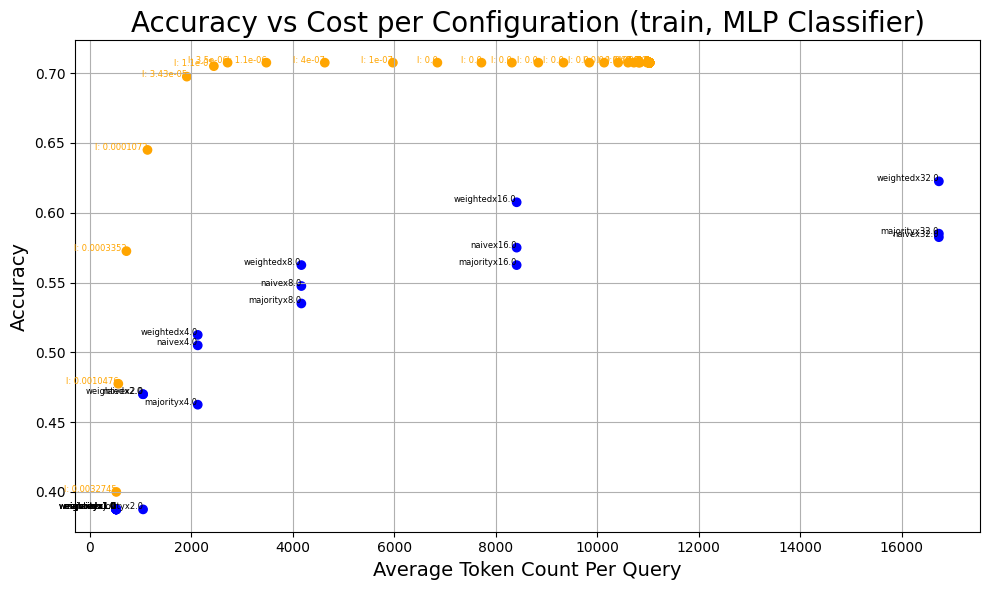

In [ ]:
# Create color labels and text labels (sklearn MLPClassifier)
colors = ['orange' if (row['method']) == -1 else 'blue'
          for _, row in query_optimal_static_df.iterrows()]

text_labels = ["qa" if (row['method']) == -1
               else f"{row['method']}x{row['N']}"
               for _, row in query_optimal_static_df.iterrows()]

print(text_labels)
plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_static_df["token_count"], query_optimal_static_df["indicator"], color=colors)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='black')
    elif label == "qa":
        plt.annotate(f"l: {round(query_optimal_static_df["lambda"][i], 7)}",
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='orange')

plt.xlabel("Average Token Count Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration (train, MLP Classifier)", fontsize=20)
plt.grid(True)
plt.tight_layout()

['majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'qa', 'qa', 'majorityx2.0', 'qa', 'majorityx4.0', 'naivex2.0', 'weightedx2.0', 'qa', 'naivex4.0', 'weightedx4.0', 'majorityx8.0', 'naivex8.0', 'qa', 'weightedx8.0', 'majorityx16.0', 'naivex16.0', 'naivex32.0', 'majorityx32.0', 'weightedx16.0', 'weightedx32.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa']


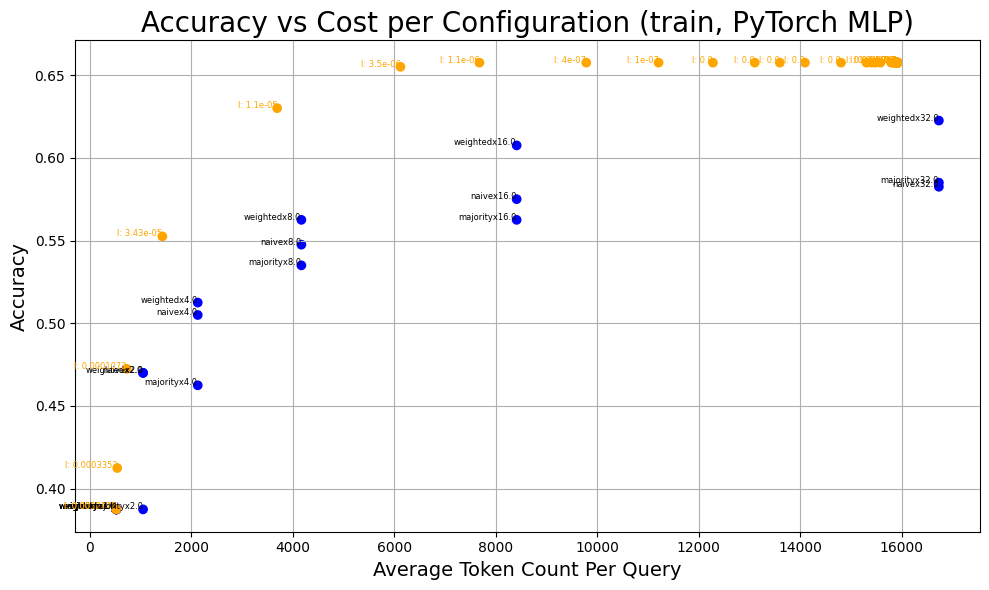

In [ ]:
# Create color labels and text labels (pyTorch MLP)
colors = ['orange' if (row['method']) == -1 else 'blue'
          for _, row in query_optimal_static_df.iterrows()]

text_labels = ["qa" if (row['method']) == -1
               else f"{row['method']}x{row['N']}"
               for _, row in query_optimal_static_df.iterrows()]

print(text_labels)
plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_static_df["token_count"], query_optimal_static_df["indicator"], color=colors)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='black')
    elif label == "qa":
        plt.annotate(f"l: {round(query_optimal_static_df["lambda"][i], 7)}",
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='orange')

plt.xlabel("Average Token Count Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration (train, PyTorch MLP)", fontsize=20)
plt.grid(True)
plt.tight_layout()

['majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx1.0', 'naivex1.0', 'weightedx1.0', 'majorityx2.0', 'qa', 'majorityx4.0', 'naivex2.0', 'weightedx2.0', 'qa', 'naivex4.0', 'weightedx4.0', 'majorityx8.0', 'naivex8.0', 'weightedx8.0', 'majorityx16.0', 'qa', 'naivex16.0', 'naivex32.0', 'majorityx32.0', 'weightedx16.0', 'weightedx32.0', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa', 'qa']


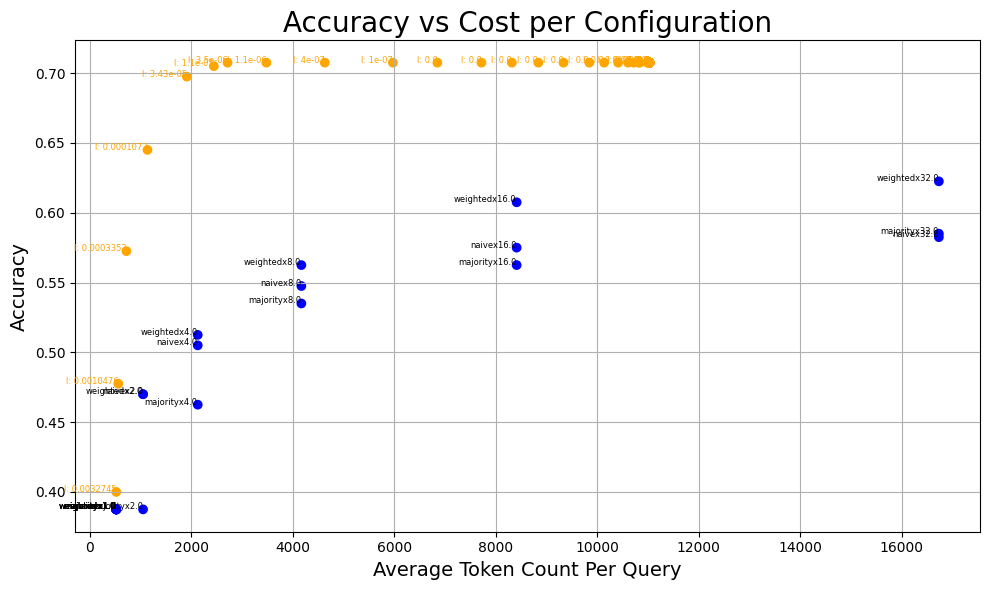

In [ ]:
# Create color labels and text labels
colors = ['orange' if (row['method']) == -1 else 'blue'
          for _, row in query_optimal_static_df.iterrows()]

text_labels = ["qa" if (row['method']) == -1
               else f"{row['method']}x{row['N']}"
               for _, row in query_optimal_static_df.iterrows()]

print(text_labels)
plt.figure(figsize=(10, 6))
plt.scatter(query_optimal_static_df["token_count"], query_optimal_static_df["indicator"], color=colors)

# Annotate each point
for i, label in enumerate(text_labels):
    if label != "qa":
        plt.annotate(label,
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='black')
    elif label == "qa":
        plt.annotate(f"l: {round(query_optimal_static_df["lambda"][i], 7)}",
                    (query_optimal_static_df["token_count"][i], query_optimal_static_df["indicator"][i]),
                    textcoords="offset points", xytext=(0, 0), ha='right', fontsize=6, color='orange')

plt.xlabel("Average Token Count Per Query", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs Cost per Configuration", fontsize=20)
plt.grid(True)
plt.tight_layout()

# plt.savefig("figs/accuracy_vs_cost_by_config3", dpi=300, bbox_inches='tight')

# notes: make sure we are plotting the accuracy. the probe should pick the weighted response.
# should not go below the blue dots. (check what you are actually plotting).